# Linear Regression

*Linear Regression* is one of the simplest yet fundamental statistical learning techniques. It is a great initial step towards more advanced and computationally demanding methods. 

This article aims to cover a statistically sound approach to Linear Regression and its inferences while tying these to popular statistical packages and reproducing the results.

We first begin with a brief description of Linear Regression and move on to investigate it in light of a dataset.

## 1 - Description

Linear regression examines the relationaship between a dependent variable and one or more independent variables. Linear regression with $p$ independent variables focusses on fitting a straight line in $p+1$-dimensions that passes as close as possible to the data points in order to reduce error.

General Characteristics:

- A supervised learning technique
- Useful for predicting a quantitative response
- Linear Regression attempts to fit a function to predict a response variable
- The problem is reduced to a parametric problem of finding a set of parameters
- The function shape is limited (as a function of the parameters)

## 2- Advertising and Housing Datasets

Here we will use two datasets in order to get a feel of what Linear Regression is capable of.

First we use the Advertising dataset which is obtained from http://www-bcf.usc.edu/~gareth/ISL/data.html and contains 200 datapoints of sales of a particular product, and TV, newspaper and radio advertising budgets (all figures are in units of $1,000s). We will predict sales of a product given its advertising budgets.

Then we use the HousePrice dataset which is obtained from https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data and contains 1460 houses along with many properties (only quantitative properties) including their sales prices. We will preduct the sale price of a property given certain parameters that characterise it.

First we import the required libraries

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from numpy.random import RandomState
import math
%matplotlib inline

import statsmodels.api as sm
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

import random

Then we import the datasets

In [2]:
# Import Advertising dataset (http://www-bcf.usc.edu/~gareth/ISL/data.html)
advert = pd.read_csv("Advertising.csv").iloc[:,1:]

# Import House Prices dataset - Only quantitative fields and cleaned (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)
housePrice = pd.read_csv("HousePrice.csv").iloc[:,1:]

In [3]:
print("Number of observations (n) in advertising file =",advert.shape[0])
print("Number of predictor variables (p) in advertising file =",advert.shape[1]-1)
print()
print("Advertising.csv")
display(advert.head())

Number of observations (n) in advertising file = 200
Number of predictor variables (p) in advertising file = 3

Advertising.csv


,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [4]:
print("Number of observations (n) in house-prices file =",housePrice.shape[0])
print("Number of predictor variables (p) in house-prices file =",housePrice.shape[1]-1)
print()
print("HousePrice.csv")
display(housePrice.head())

Number of observations (n) in house-prices file = 1460
Number of predictor variables (p) in house-prices file = 34

HousePrice.csv


,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,8450,7,5,2003,2003,196.0,706,0,150,856,...,0,61,0,0,0,0,0,2,2008,208500
1,9600,6,8,1976,1976,0.0,978,0,284,1262,...,298,0,0,0,0,0,0,5,2007,181500
2,11250,7,5,2001,2002,162.0,486,0,434,920,...,0,42,0,0,0,0,0,9,2008,223500
3,9550,7,5,1915,1970,0.0,216,0,540,756,...,0,35,272,0,0,0,0,2,2006,140000
4,14260,8,5,2000,2000,350.0,655,0,490,1145,...,192,84,0,0,0,0,0,12,2008,250000


For the Advertising dataset the response variable is "sales". The predictor variables are "TV", "radio" and "newspaper". It's useful to visually inspect the data and see how each variable relates to the others. Using seaborn we can produce a pairplot of the data seen below:

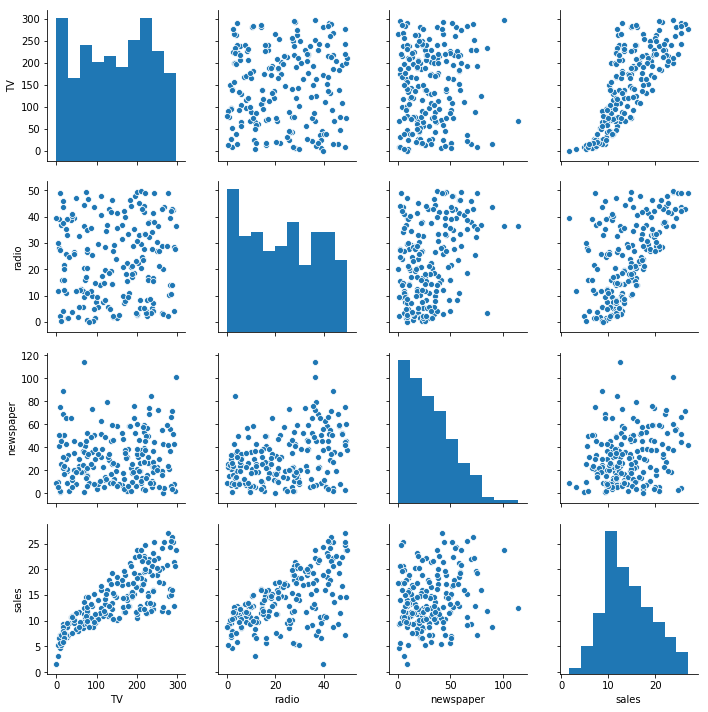

In [5]:
ax = sns.pairplot(data=advert)

By looking at a pairplot to see the simple relationships between the variables, we see a strong positive correlation between sales and TV. A similar relationship between sales and radio is also observed. Newspaper and radio seem to have a slight positive correlation also. We can use the Pearson correlation given by:

$$corr=\frac{Cov(X,Y)}{\sigma_{X}\sigma_{Y}}$$

where $X$ and $Y$ are random variables, $Cov(X,Y)$ is the Covariance of $X$ and $Y$ and $\sigma_{X}$ is the standard deviation of $X$. This allows us to  examine the correlations between the parameters as seen in the correlation matrix below.

In [6]:
advert.corr()

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


We may want to fit a line to this data which is as close as possible. We describe the Linear Regression model next and then apply it to this data.

## 3- Linear Regression

The idea behind *Linear Regression* is that we reduce the problem of estimating the response variable, $Y$ = sales, by assuming there is a linear function of the predictor variables, $X_1$ = TV, $X_2$ = radio and $X_3$ = newspaper which describes $Y$. This reduces the problem to that of solving for the parameters $\beta_0$, $\beta_1$, $\beta_2$ and $\beta_3$ in the equation:

$$Y \approx \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \epsilon$$

where $\epsilon$ is an error term. After approximating the coefficients $\beta_i$ as $\hat{\beta}_i$, we obtain an approximation, $\hat{Y}$ of $Y$. The coefficients $\hat{\beta}_i$ are obtained using the observed realisations of the random variables $X_i$. Namely, $X_i = (x_{1i},x_{2i},x_{3i},...,x_{ni})$ are n observations of $X_i$ where $i = 1,2,...,p$. 

We first limit the problem to $p=1$. For example, we are looking to estimate the coefficients in the equation

$$Y \approx \beta_0 + \beta_1 X_1 + \epsilon$$

using the $n$ data points $(x_{11},y_{11}),(x_{21},y_{21}),...,(x_{n1},y_{n1})$. We can define the prediction discrepency of a particular prediction as the difference between the observed value and the predicted value. This is representated in mathematical notation for observation $i$ as $y_i - \hat{y}_i$. Letting $\hat{Y} = \hat{\beta}_0 + \hat{\beta}_1 X_1$ we have $y_i - \hat{y}_i = \epsilon_i$. i.e. the error in the prediction of point observation $i$ (also called the ith *residual*).

In summary, we are looking for a straight line to fit to the following data points as well as possible:

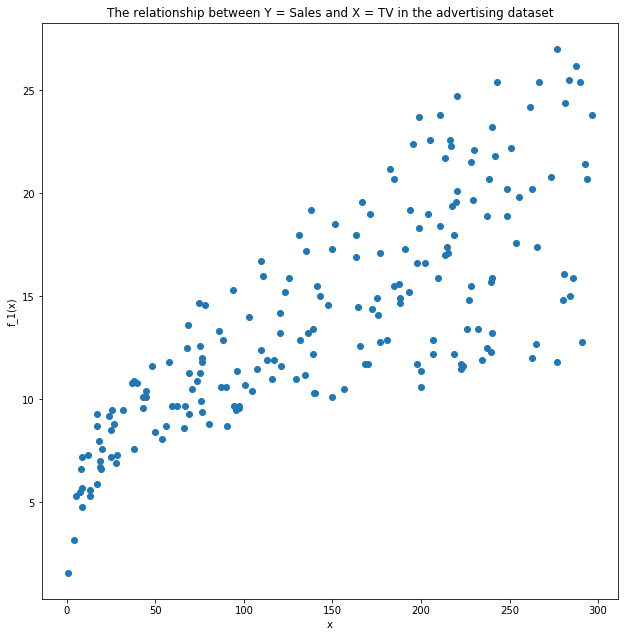

In [7]:
# Get the figure handle and set figure size
fig = plt.figure(figsize=(8,8))

# Get the axis
axes = fig.add_axes([0.1,0.1,1,1])

# Plot onto the axis
axes.scatter(data=advert, x='TV', y='sales')

# Set the labels and title
axes.set_xlabel('x')
axes.set_ylabel('f_1(x)')
axes.set_title('The relationship between Y = Sales and X = TV in \
the advertising dataset')
plt.show()

In order to calculate appropriate values for parameters $\beta_i$, we would need a method of defining what it means for a line to be a good fit. A popular method is "Ordinary Least Squares". This method relies on minimising the Residual Sum of Squared errors (RSS). i.e. we are looking to minimise $RSS = \sum_{i=1}^n \epsilon_i^2$. While this intuitively makes sense, this can also be arrived at using a *Maximum Likelihood Estimation* (MLE) approach (see Appendix A2).

For the 1-parameter case we have that (the semi-colon below means 'the value of the parameters' given 'the data we have observed') 

$$RSS(\hat{\beta}_0,\hat{\beta}_1;X) = \sum_{i=1}^n \epsilon_i^2 = \sum_{i=1}^n (y_i-\hat{\beta}_0 - \hat{\beta}_1 x_i)^2$$

We would like to find the parameters $(\beta_0,\beta_1)$ which minimise RSS. We first find the partial derivates:

$$\frac{\partial RSS}{\partial \hat{\beta_0}} = -2 [ \sum_{i=1}^n y_i - \sum_{i=1}^n \hat{\beta}_0 - \sum_{i=1}^n \hat{\beta}_1 x_i]$$

$$\frac{\partial RSS}{\partial \hat{\beta_1}} = -2 [ \sum_{i=1}^n y_i x_i - \sum_{i=1}^n \hat{\beta}_0 x_i - \sum_{i=1}^n \hat{\beta}_1 x_i^2]$$

Then setting these to zero and solving

$$\frac{\partial RSS}{\partial \hat{\beta_0}} = 0 \implies  \hat{\beta}_0 = \frac{\sum_{i=1}^n y_i - \hat{\beta}_1 \sum_{i=1}^n y_i}{n} = \frac{n \bar{y} - \hat{\beta}_1 n \bar{x}}{n} = \bar{y} - \hat{\beta}_1 \bar{x}$$

$$\frac{\partial RSS}{\partial \hat{\beta_1}} = 0 \implies  \sum_{i=1}^n y_i x_i - \hat{\beta}_0 \sum_{i=1}^n x_i - \hat{\beta}_1 \sum_{i=1}^n x_i^2 = 0$$

$$\implies \hat{\beta}_1 = \frac{n \bar{y} \bar{x} - \sum_{i=1}^n y_i x_i}{n \bar{x}^2 - \sum_{i=1}^n x_i^2} = \frac{\sum_{i=1}^n y_i x_i - n \bar{y} \bar{x}}{\sum_{i=1}^n x_i^2 - n \bar{x}^2} = \frac{\sum_{i=1}^n y_i x_i - n \bar{y} \bar{x} - n \bar{y} \bar{x} + n\bar{y} \bar{x}}{\sum_{i=1}^n x_i^2 - n \bar{x}^2 -n\bar{x}^2 + n\bar{x}^2}$$

$$= \frac{\sum_{i=1}^n x_i y_i - \sum_{i=1}^n y_i \bar{x} - \sum_{i=1}^n x_i \bar{y}  + \sum_{i=1}^n \bar{y} \bar{x}}{\sum_{i=1}^n x_i^2 - \sum_{i=1}^n x_i \bar{x} - \sum_{i=1}^n x_i \bar{x} + \sum_{i=1}^n \bar{x}^2},$$

where we used $n\bar{y} \bar{x} = \sum_{i=1}^n y_i \bar{x} = \sum_{i=1}^n x_i \bar{y}$ and $n\bar{x}^2 = n\bar{x} \bar{x} = \sum_{i=1}^n x_i \bar{x}$. Factorising

$$\hat{\beta}_1 = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2}$$

Additionally, we can show that the point $(\bar{x},\bar{y})$ lies on the regression line (see Appendix A3).

We have now found the values of $(\hat{\beta}_0,\hat{\beta}_1)$ which corresponds to the extrema of RSS. We will still need to show that this is indeed a minima.

From Calculus, we know that if $\frac{\partial^2 RSS}{\partial \hat{\beta}_0 ^2} \frac{\partial^2 RSS}{\partial \hat{\beta}_1 ^2} - (\frac{\partial^2 RSS}{\partial \hat{\beta}_0 \partial \hat{\beta}_1})^2 > 0$, this is an extrema and not an inflexion point. Additionally, if $\frac{\partial^2 RSS}{\partial \hat{\beta}_0 ^2} > 0$ and $\frac{\partial^2 RSS}{\partial \hat{\beta}_1 ^2} > 0$ this is a minima.

We have that

$$\frac{\partial^2 RSS}{\partial \hat{\beta}_0 ^2} = 2n > 0$$
$$\frac{\partial^2 RSS}{\partial \hat{\beta}_1 ^2} = 2 \sum_{i=1}^n x_i^2 > 0$$
$$\frac{\partial^2 RSS}{\partial \hat{\beta}_0 \partial \hat{\beta}_1} = 2 \sum_{i=1}^n x_i$$

So,

$\frac{\partial^2 RSS}{\partial \hat{\beta}_0 ^2} \frac{\partial^2 RSS}{\partial \hat{\beta}_1 ^2} - (\frac{\partial^2 RSS}{\partial \hat{\beta}_0 \partial \hat{\beta}_1})^2 = (2n) (2 \sum_{i=1}^n x_i^2) - (2 \sum_{i=1}^n x_i)^2 > 0 \; \forall \; n>1$ (see Appendix A1).

This means that this is indeed a minima (since we have satisfied the conditions stated above). 

The equation

$$\hat{Y} = \hat{\beta}_0 + \hat{\beta}_1 X_1$$

then defines a straight line of best fit which minimises the expected value of the errors (residuals). From the form of this line, we can see that $\hat{\beta}_0$ corresponds to the value of $\hat{Y}$ if the independent variable $X_1$ is zero. $\hat{\beta}_1$ is then the gradient.

In the following we construct 3 functions dependent on a single independent variable and attach an error term and calculate the best fit. The three functions are chosen as:

1- $f_1(x) = 4.67 + 5.07*x$

2- $f_2(x) = 4.67 + 5.07*x^2$

3- $f_3(x) = 4.67 + 5.07*sin(x/20)$

In [8]:
#f_1(x)=4.67+5.07∗x
def f_1(x):
    return 4.67 + 5.07*x

#f_2(x)=4.67+5.07∗x2
def f_2(x):
    return 4.67 + 5.07*x**2

#f_3(x)=4.67+5.07∗sin(x/20)
def f_3(x):
    return 4.67 + 5.07*math.sin(x/20)

In [9]:
# Set the seed
r = np.random.RandomState(101)

# Choose 1000 random observations for x between 0 and 100
X = 100*r.rand(1000)

#Error term with sigma = 10, mu = 0, randn samples from the standard normal distribution
E_1 = 10*r.randn(1000)

#Error term with sigma = 500, mu = 0
E_2 = 500*r.randn(1000)

#Error term with sigma = 1, mu = 0
E_3 = 1*r.randn(1000)

#Response variables
Y_1 = list(map(f_1,X))+E_1
Y_2 = list(map(f_2,X))+E_2
Y_3 = list(map(f_3,X))+E_3

In the above, *s $\times$ r.randn(n)* samples n points from the $N(0,s^2)$ distribution. First we look at what $f_1$ looks like

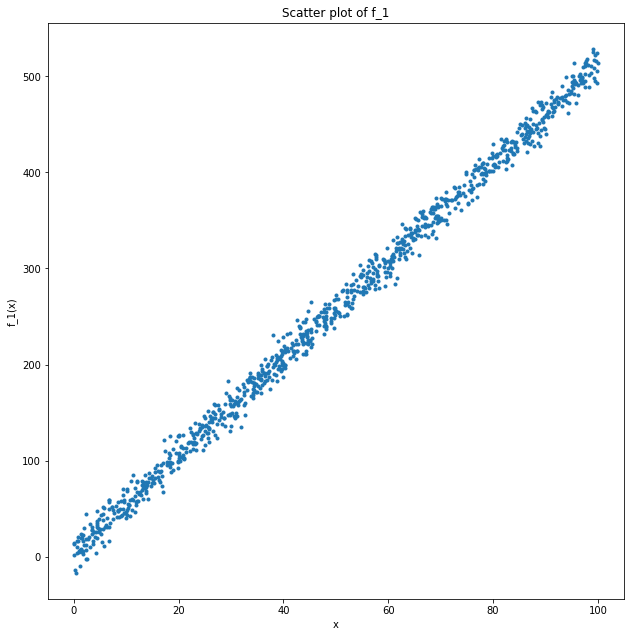

In [10]:
# Plot
fig = plt.figure(figsize=(8,8))
axes = fig.add_axes([0.1,0.1,1,1])
axes.plot(X,Y_1,'.')

# Set labels and title
axes.set_xlabel('x')
axes.set_ylabel('f_1(x)')
axes.set_title('Scatter plot of f_1')

plt.show()

The task is to fit the model $\hat{Y} = \hat{\beta}_0 + \hat{\beta}_1 X_1$ to the data. We know that 

$$\hat{\beta}_1 = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2}$$

and

$$\hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x}$$

We can calculate these as below

In [11]:
#Find the mean of the data for f_1
x_bar1 = np.mean(X)
y_bar1 = np.mean(Y_1)

numerator = 0
denominator = 0

for i in range(len(Y_1)):
    # Add to the numerator for beta_1
    numerator += (X[i] - x_bar1)*(Y_1[i] - y_bar1)
    
    # Add to the denominator for beta_1
    denominator += (X[i] - x_bar1)**2
    
beta1_1 = numerator/denominator
beta1_0 = y_bar1 - beta1_1*x_bar1

print('Y = {beta_0} + {beta_1} * X'.\
      format(beta_0 = beta1_0, beta_1 = beta1_1))

Y = 5.50124312485292 + 5.064254524922961 * X


Below, we see how the line defined by the equation above fits the data for $f_1$

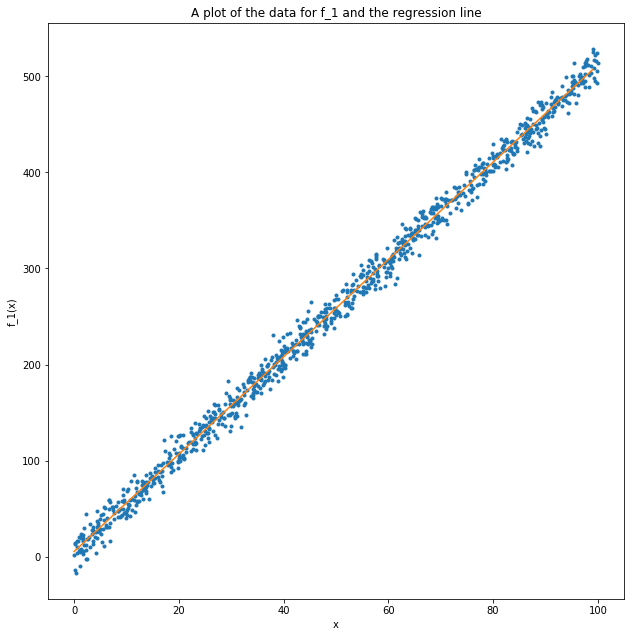

In [12]:
# 1000 linearly spaced numbers
x1 = np.linspace(0,99,1000) 

# The equation using the betas above
y1 = beta1_0 + beta1_1 * x1 

# Plot the observed data
fig = plt.figure(figsize=(8,8))
axes = fig.add_axes([0.1,0.1,1,1])
axes.plot(X,Y_1,'.')

# Plot the regression line
axes.plot(x1,y1)

# Set labels and title
axes.set_xlabel('x')
axes.set_ylabel('f_1(x)')
axes.set_title('A plot of the data for f_1 and the regression line')

plt.show()

Let's see what the residuals look like by plotting them. The residuals require the knowledge of the actual response variables so that we can compare them with the predicted response variables. So we use the regression line above to predict the response variable using the observed predictor variables. Then we plot them using a histogram to gain some insight into their distribution

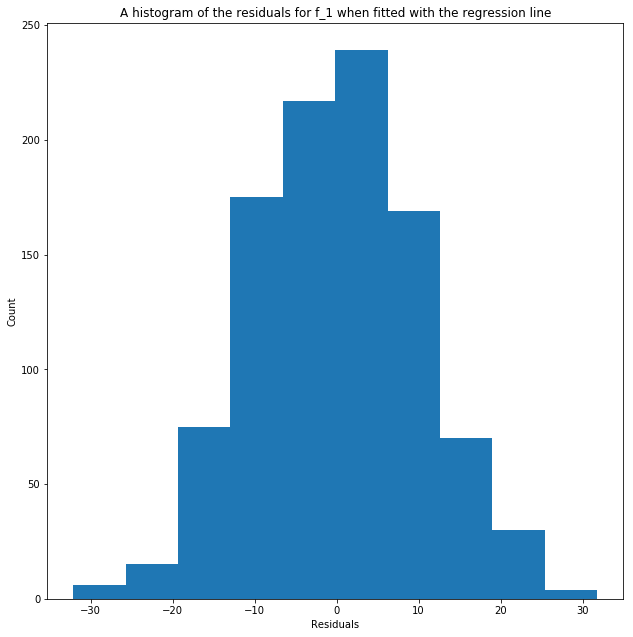

This is roughly a normal distribution with mean -1.2157386208855315e-14 
and standard deviation 10.08588495757817


In [13]:
# The fitted values are the predicted values given the observed values
y1_fitted = beta1_0 + beta1_1 * X

# The residuals are the differences between our predicted values and 
# the observed responses
Res_1 = y1_fitted - Y_1

# Plot the residuals
fig = plt.figure(figsize=(8,8))
axes = fig.add_axes([0.1,0.1,1,1])
axes.hist(Res_1)

# Set labels and title
axes.set_xlabel('Residuals')
axes.set_ylabel('Count')
axes.set_title('A histogram of the residuals for f_1 when \
fitted with the regression line')

plt.show()

print('This is roughly a normal distribution with mean {mean} \n\
and standard deviation {std}'.format(mean=np.mean(Res_1),std=np.std(Res_1)))

Since the residuals are roughly normally distributed, our model may be a good choice. In fact, the standard deviation for the residuals was roughly equal to the standard deviation for the error term when we constructed the function $f_1$. A model may suffer from two types of error: 
* error due to a discrepancy between the chosen function shape (here a linear model) and the true function shape (this is the reducible error), and 
* error due to random noise (this is the irreducible error). We can see here that the residuals are from irreducible error. 

Above we fitted a linear model to our 'designed' linear data. The error terms we expect to get are irreducible and a result of the error term E1 added above.

Now let's do the same for f_2.

Text(0.5, 1.0, 'Scatter plot of f_2')

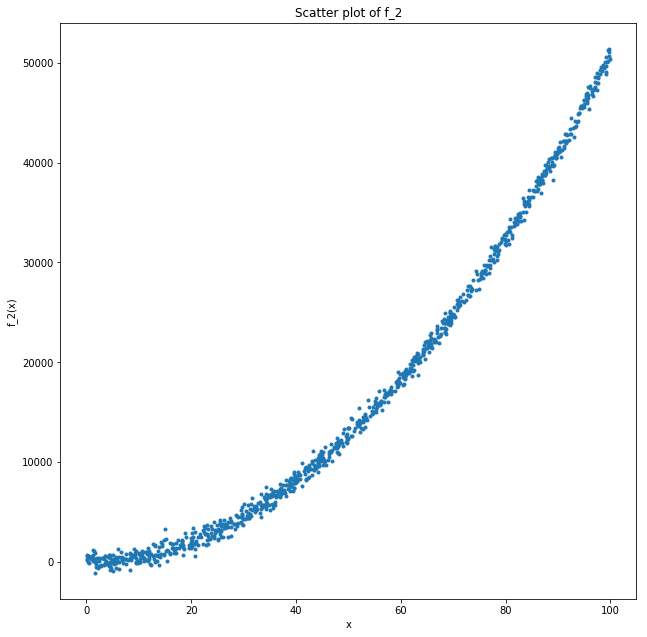

In [14]:
# Get figure handle
fig = plt.figure(figsize=(8,8))

# Get axis handle and specify size
axes = fig.add_axes([0.1,0.1,1,1])

# Plot onto this axis
axes.plot(X,Y_2,'.')

# Set the axis labels
axes.set_xlabel('x')
axes.set_ylabel('f_2(x)')
axes.set_title('Scatter plot of f_2')

In [15]:
#Find the mean of the data for f_2
x_bar2 = np.mean(X)
y_bar2 = np.mean(Y_2)

numerator = 0
denominator = 0

for i in range(len(Y_2)):
    # Add to the numerator for beta_1
    numerator += (X[i] - x_bar2)*(Y_2[i] - y_bar2)
    
    # Add to the denominator for beta_1
    denominator += (X[i] - x_bar2)**2
    
beta2_1 = numerator/denominator
beta2_0 = y_bar2 - beta2_1*x_bar2

print('Y = {beta_0} + {beta_1} * X'.format(beta_0 = beta2_0, beta_1 = beta2_1))

Y = -8445.98030682202 + 506.16066894401735 * X


Below, we see how the line defined by the equation above fits the data for $f_2$

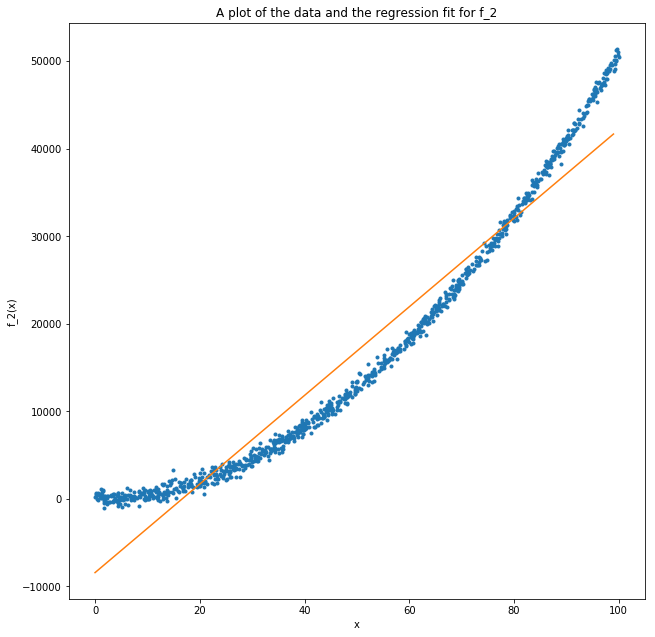

In [16]:
# 1000 linearly spaced numbers
x2 = np.linspace(0,99,1000) 

# The predicted responses of these 1000 numbers
y2 = beta2_0 + beta2_1 * x2

# Plot
fig = plt.figure(figsize=(8,8))
axes = fig.add_axes([0.1,0.1,1,1])
axes.plot(X,Y_2,'.')
axes.plot(x2,y2)

# Set labels and title
axes.set_xlabel('x')
axes.set_ylabel('f_2(x)')
axes.set_title('A plot of the data and the regression fit for f_2')

plt.show()

We can then look at the residuals plot as we did before

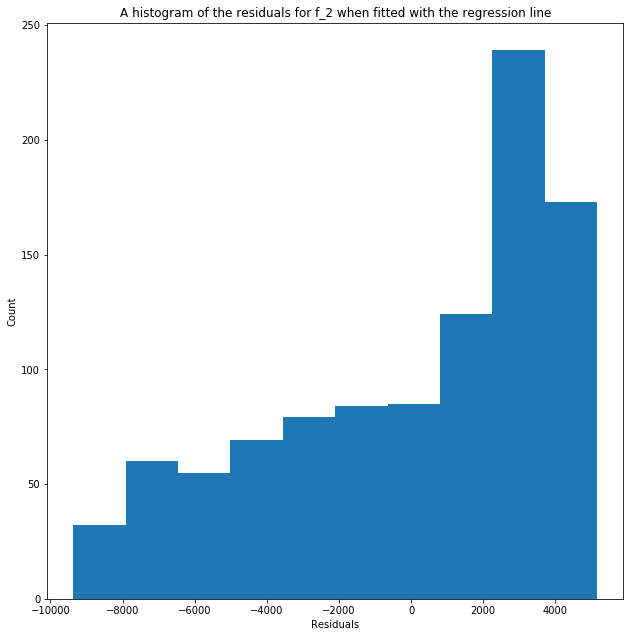

The residuals are certainly not from a normal distribution


In [17]:
# The fitted values are the predicted values given the observed values
y2_fitted = beta2_0 + beta2_1 * X

# The residuals are the differences between our predicted values and 
# the observed responses
Res_2 = y2_fitted - Y_2


# Plot the residuals
fig = plt.figure(figsize=(8,8))
axes = fig.add_axes([0.1,0.1,1,1])
axes.hist(Res_2)

# Set labels and title
axes.set_xlabel('Residuals')
axes.set_ylabel('Count')
axes.set_title('A histogram of the residuals for f_2 when fitted with the regression line')

plt.show()

print('The residuals are certainly not from a normal distribution')

This shows that the linear model we have chosen may not be a good choice. We can try $X^2$ as a parameter instead of $X$ in our linear model. This way, we are transforming an existing parameter to form a new parameter.

In [18]:
# Create X^2 parameter
X_2 = X**2

#Find the mean of the data for f_2
x_bar22 = np.mean(X_2)
y_bar22 = np.mean(Y_2)

numerator = 0
denominator = 0

for i in range(len(Y_2)):
    # Calculate the numerator for beta_1
    numerator += (X_2[i] - x_bar22)*(Y_2[i] - y_bar22)
    
    # Calculate the denominator for beta_1
    denominator += (X_2[i] - x_bar22)**2
    
beta22_1 = numerator/denominator
beta22_0 = y_bar22 - beta22_1*x_bar22

print('Y = {beta_0} + {beta_1} * X^2'.format(beta_0 = beta22_0, beta_1 = beta22_1))

Y = 14.470063153316005 + 5.075020979320466 * X^2


Below, we see how the new line defined by the equation above fits the data for $f_2$

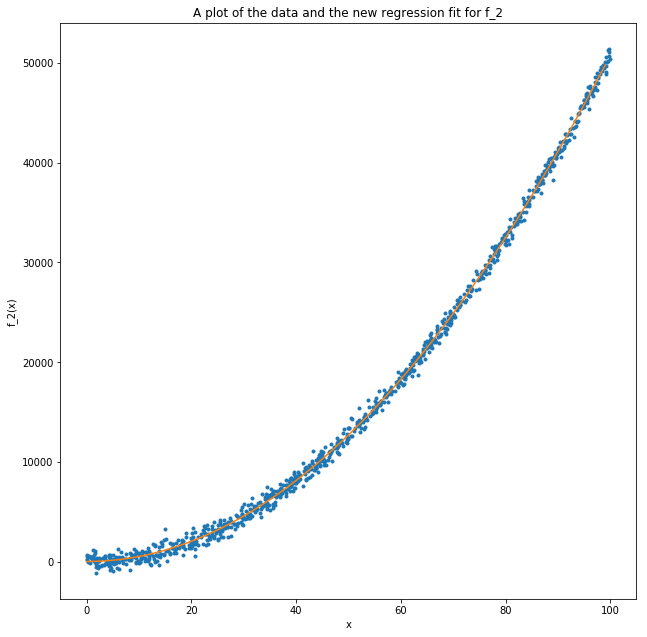

In [19]:
# 1000 linearly spaced numbers
x22 = np.linspace(0,99,1000)

# Predicted responses to the 1000 numbers
y22 = beta22_0 + beta22_1 * ((x22)**2)

# Plot this regression line and the data
fig = plt.figure(figsize=(8,8))
axes = fig.add_axes([0.1,0.1,1,1])
axes.plot(X,Y_2,'.')
axes.plot(x22,y22)

# Set labels and title
axes.set_xlabel('x')
axes.set_ylabel('f_2(x)')
axes.set_title('A plot of the data and the new regression fit for f_2')
plt.show()


We see a much better fit. Now we investigate the residuals to see if the new regression fit using $X^2$ as a parameter yields residuals that look more normally distributed as has been assumed by the model architecture

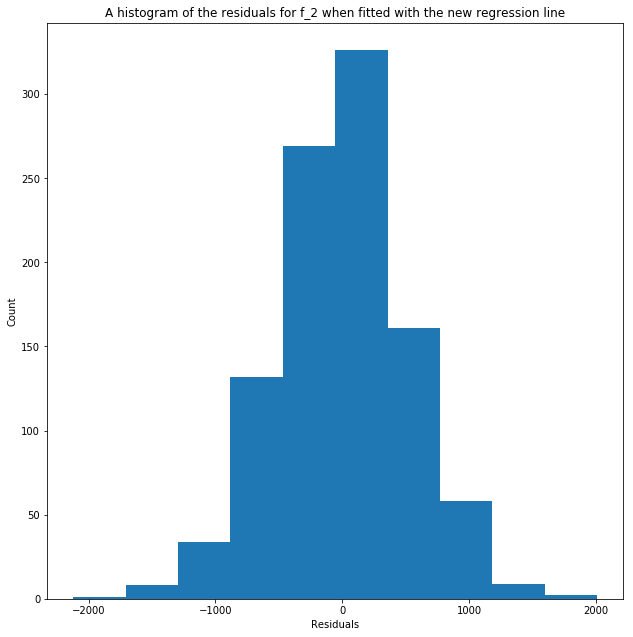

This is roughly a normal distribution with mean -1.1250449460931123e-12 and standard deviation 518.5583078222347


In [20]:
# The fitted values are the predicted values given the observed values
y22_fitted = beta22_0 + beta22_1 * X**2

# The residuals are the differences between our predicted values and 
# the observed responses
Res_22 = y22_fitted - Y_2

# Plot the residuals
fig = plt.figure(figsize=(8,8))
axes = fig.add_axes([0.1,0.1,1,1])
axes.hist(Res_22)

# Set labels and title
axes.set_xlabel('Residuals')
axes.set_ylabel('Count')
axes.set_title('A histogram of the residuals for f_2 when fitted with the new regression line')

plt.show()

print('This is roughly a normal distribution with mean {mean} and standard deviation {std}'\
      .format(mean=np.mean(Res_22),std=np.std(Res_22)))

This shows that we can transform an independent variable and apply linear regression in order to *regress* the response variable onto the transformed explanatory variable. This increases the power of linear regression techniques. Note also that the standard deviation from the residual distribution is close to the 500 for the errors when the function was created.

Now let's apply linear regression to f_3 in a similar manner

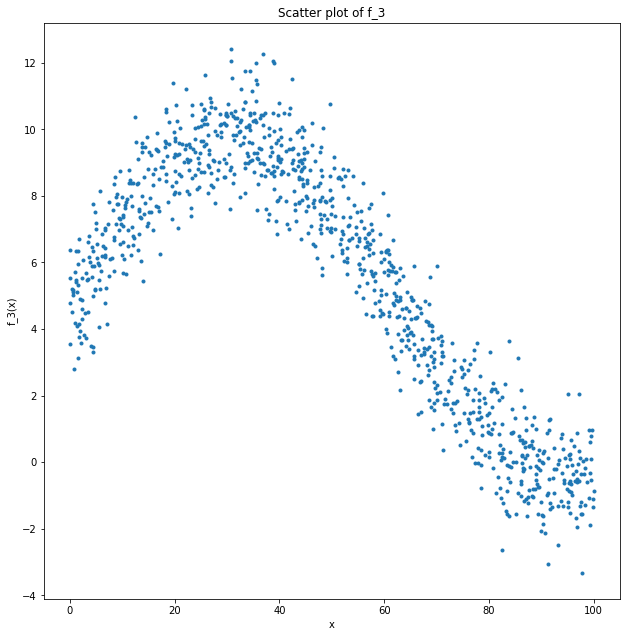

In [21]:
# Get figure handle
fig = plt.figure(figsize=(8,8))

# Get axis handle and specify size
axes = fig.add_axes([0.1,0.1,1,1])

# Plot onto this axis
axes.plot(X,Y_3,'.')

# Set the axis labels
axes.set_xlabel('x')
axes.set_ylabel('f_3(x)')
axes.set_title('Scatter plot of f_3')

plt.show()

It is very clear from the above scatter plot that we will not be able to get away with fitting a linear line to the data. This is a hint that we should use transformed variables. But let's carry out a linear fit to show that the results can be misleading when we only consider the residuals plot to assess the quality of fit

In [22]:
#Find the mean of the data for f_3
x_bar3 = np.mean(X)
y_bar3 = np.mean(Y_3)

numerator = 0
denominator = 0

for i in range(len(Y_3)):
    numerator += (X[i] - x_bar3)*(Y_3[i] - y_bar3)
    denominator += (X[i] - x_bar3)**2
    
beta3_1 = numerator/denominator
beta3_0 = y_bar3 - beta3_1*x_bar3

print('Y = {beta_0} + {beta_1} * X'.format(beta_0 = beta3_0, beta_1 = beta3_1))

Y = 10.511143457700811 + -0.1011987818100197 * X


Below, we see how the line defined by the equation above fits the data for $f_3$

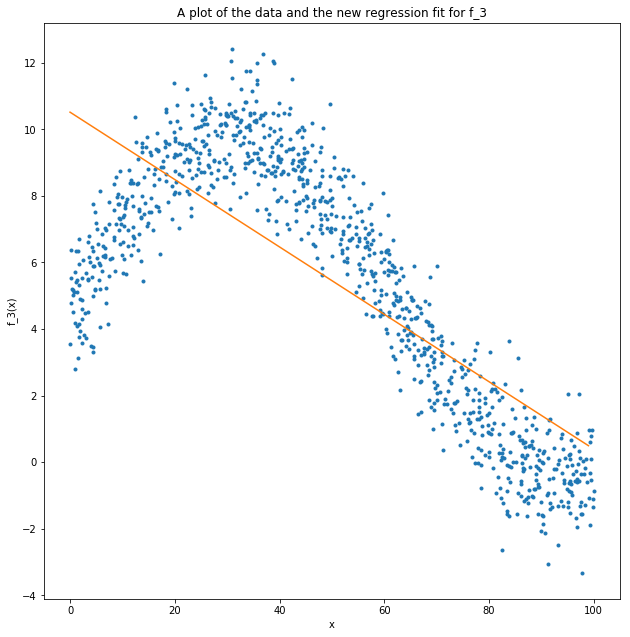

In [23]:
# 1000 linearly spaced numbers
x3 = np.linspace(0,99,1000) 

# Predict the response for those numbers
y3 = beta3_0 + beta3_1 * x3

# Plot both the data and the fit
fig = plt.figure(figsize=(8,8))
axes = fig.add_axes([0.1,0.1,1,1])
axes.plot(X,Y_3,'.')
axes.plot(x3,y3)

# Set the labels and title
axes.set_xlabel('x')
axes.set_ylabel('f_3(x)')
axes.set_title('A plot of the data and the new regression fit for f_3')

plt.show()


We now assess the residuals

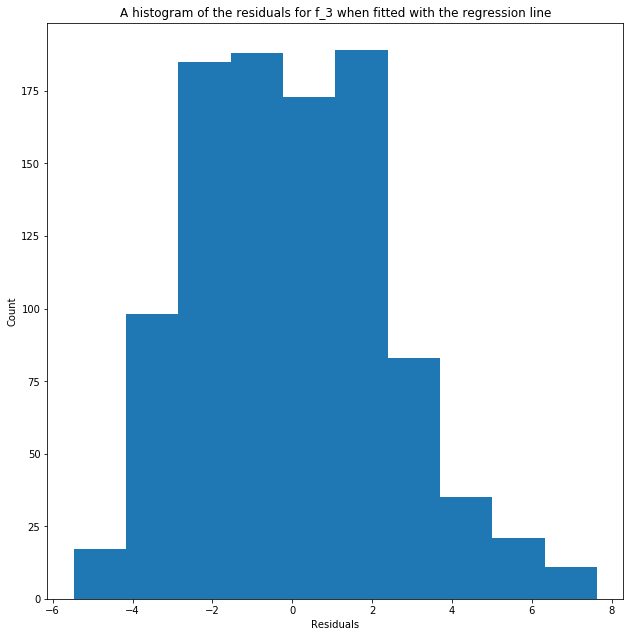

This not a normal distribution but it is not that far off.


In [24]:
# The fitted values are the predicted values given the observed values
y3_fitted = beta3_0 + beta3_1 * X

# The residuals are the differences between our predicted values and 
# the observed responses
Res_3 = y3_fitted - Y_3

# Plot the residuals
fig = plt.figure(figsize=(8,8))
axes = fig.add_axes([0.1,0.1,1,1])
axes.hist(Res_3)

# Set labels and title
axes.set_xlabel('Residuals')
axes.set_ylabel('Count')
axes.set_title('A histogram of the residuals for f_3 when fitted with the regression line')

plt.show()

print('This not a normal distribution but it is not that far off.')

### Alternative View

Often in Machine Learning, we pose a hypothesis ($h_{\theta}(X)$) and a cost function ($J(\theta)$) and proceed to minimise this cost function. Here, $X$ is the data and $\theta$ is a vector of parameters (such as the $\beta$ in the Linear Regression models above).

For Linear Regression as stated above, the hypothesis function is that there is a straight line passing through all the data points:

$$h_{\theta}(X) = \theta_0 + \theta_1 X_1 + \theta_2 X_2 + \theta_3 X_3 + ... = X \theta$$

The Cost function is the least squares sum residuals (eventually written in index notation):

$$J(\theta) = \sum_{i=1}^n e_i^2 = \sum_{i=1}^n (h_{\theta}(X^{(i)}) - Y^{(i)})^2 = (X \theta - Y)^T (X \theta - Y) = (X \theta)^T X\theta - 2 (X \theta)^T Y + Y^T Y = \theta_j x_{ji} x_{ij} \theta_{j} - 2 \theta_j x_{ji} y_i$$

where the superscript $^{(i)}$ refers to the ith observation. Taking the derivative of the cost function:

$$\frac{\partial J(\theta)}{\partial \theta_k} = 2 x_{ki} x_{ik} \theta_k - 2 x_{ki} y_i$$

Setting this to zero for all $k$ and solving:

$$\theta = (X^T X)^{-1} X^T Y$$

Let's test this out with the sine curve above by considering $X$,$X^2$ and $X^3$ as predictor variables.

In [25]:
# Calculate x^2
X2 = X**2

# Calculate X^3
X3 = X**3

# Combine into a single array (n X 3)
X_full = np.concatenate((X.reshape(-1,1),X2.reshape(-1,1),X3.reshape(-1,1)),axis=1)

# Create transpose (3 X n)
X_fullT = X_full.transpose()

# Calculate X^T X
XTX = X_fullT.dot(X_full)

# calculate inverse of XTX
XTX_inv = np.linalg.inv(XTX)

# Calculate theta
theta = XTX_inv.dot(X_fullT.dot(Y_3))

print('Y_3 = {} * X + {} * X^2 + {} * X^3'.format(theta[0],theta[1],theta[2]))

Y_3 = 0.7593137639570018 * X + -0.016619891556995628 * X^2 + 9.044569969875649e-05 * X^3


We can add a constant to the above by create an extra predictor full of ones

In [26]:
# Calculate x^2
X2 = X**2

# Calculate X^3
X3 = X**3

# Combine into a single array (n X 4)
X_full = np.concatenate((np.ones((Y_3.shape[0],1)),X.reshape(-1,1),X2.reshape(-1,1),X3.reshape(-1,1)),axis=1)

# Create transpose (4 X n)
X_fullT = X_full.transpose()

# Calculate X^T X (4 X 4)
XTX = X_fullT.dot(X_full)

# calculate inverse of XTX (4 X 4)
XTX_inv = np.linalg.inv(XTX)

# Calculate theta
theta = XTX_inv.dot(X_fullT.dot(Y_3))

print('Y_3 = {} + {} * X + {} * X^2 + {} * X^3'.format(theta[0],theta[1],theta[2],theta[3]))

Y_3 = 3.664431201637889 + 0.48709842203766485 * X + -0.011179330358446843 * X^2 + 5.867605764943158e-05 * X^3


We plot the original data along with this solution to the parameters to see how well it fits the data.

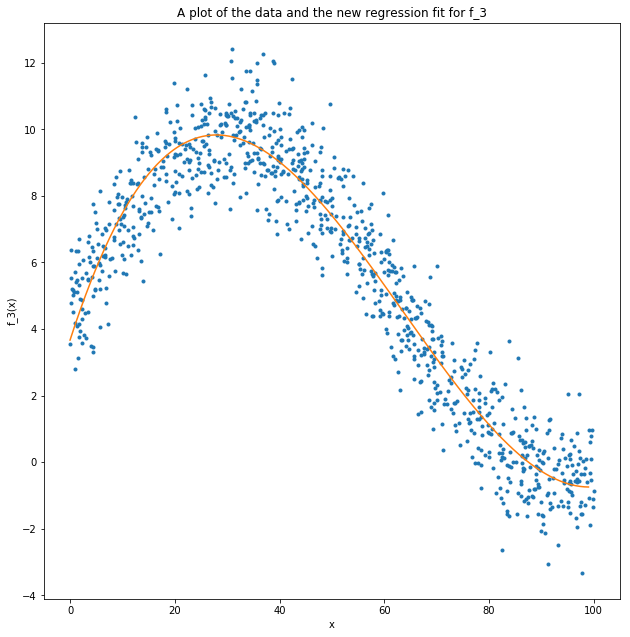

In [27]:
# 1000 linearly spaced numbers
x3 = np.linspace(0,99,1000) 
x3_2 = x3**2
x3_3 = x3**3

# Predict the response for those numbers
y3 = theta[0] + theta[1] * x3 + theta[2] * x3_2 + theta[3] * x3_3

# Plot both the data and the fit
fig = plt.figure(figsize=(8,8))
axes = fig.add_axes([0.1,0.1,1,1])
axes.plot(X,Y_3,'.')
axes.plot(x3,y3)

# Set the labels and title
axes.set_xlabel('x')
axes.set_ylabel('f_3(x)')
axes.set_title('A plot of the data and the new regression fit for f_3')

plt.show()

#### $R^2$-Statistic

Even though a plot of the residuals above does not show a clear divergence from a normal distribution, it is clear from the predicted-observed plot that this is not a good model and does not fit the data in a satisfactory manner. We therefore need additional tools in order to asses the level of fit.

A metric we can use in order to assess the goodness of the fit is the *R-Squared* ($R^2$) statistic. The $R^2$ statistic measures the percentage of variability of the response variable that is explained by the explanatory variable. This is mathematically expressed as:

$$R^2 = \frac{TSS-RSS}{TSS}$$

where $TSS = \sum_{i=1}^n(y_i - \bar{y})^2$ is the *total sum of squares* and $RSS = \sum_{i=1}^n (y_i - \hat{y}_i)^2$ is the *residual sum of squares*.

Note: Another way to assess the lack of fit is through the *Residual Squared Error* $RSE=\sqrt{ \frac{ RSS }{ n-2 } }$. 

$R^2$, as the form above suggests, is the proportion of variance that is explained. For a simple linear regression with 1 parameter (see Appendix A4):

$$R^2 = Cor(X,Y)^2 = \left( \frac{ \sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y}) }{ \sqrt{ \sum_{i=1}^n (x_i - \bar{x})^2 \sum_{i=1}^n (y_i - \bar{y})^2 } } \right) ^2$$

However, for multiple linear regression this does not hold. It is not clear how to adapt the Correlation in order to explain the fit of a multiple regression model. $R^2$ however, is a clearly defined metric which is easily extended to multiple regression.

Below, we calculate this metric for $f_3$

In [28]:
# TSS
TSS_3 = 0

# RSS
RSS_3 = 0

for i in range(len(X)):
    TSS_3 += (Y_3[i] - y_bar3)**2
    RSS_3 += (Y_3[i] - y3_fitted[i])**2

# R^2 for f_3
R_sq_3 = (TSS_3 - RSS_3)/TSS_3
print('R^2 = {}'.format(R_sq_3))

R^2 = 0.5940625125965683


This means that roughly 59% of the variability in $Y_3$ is explained by $X$. Let's calculate the $R^2$ statistic for all the models above. To do this, we create a function that accepts observed and fitted values and returns the TSS and RSS of the fit

In [29]:
def TSS_RSS(y_observed,y_fitted):
    '''
    A function that calculates the TSS and RSS of a fit given observed 
        and fitted values
    y_observed := Observed data as a list
    y_fitted := Fitted data as a list
    output := A (TSS,RSS) tuple of floats
    '''
    
    # TSS
    TSS = 0
    
    # RSS
    RSS = 0
    
    # Get the mean of the observed values
    y_bar = np.mean(y_observed)

    for i in range(len(y_observed)):
        TSS += (y_observed[i] - y_bar)**2
        RSS += (y_observed[i] - y_fitted[i])**2
        
    return TSS,RSS

Then we apply this function to the three fitted models

In [30]:
# Calculate the TSS and RSS for the fitted regression line to f_1
TSS_1, RSS_1 = TSS_RSS(Y_1,y1_fitted)

# Calculate the R^2 for the fit to f_1
R_sq_1 = (TSS_1 - RSS_1)/TSS_1
print('Model for Y_1: Explanatory variable X for Y_1 - R^2 = {}'\
      .format(R_sq_1))


# Calculate the TSS and RSS for the fitted regression line to f_2
TSS_2,RSS_2 = TSS_RSS(Y_2,y2_fitted)

# Calculate the R^2 for the fit to f_2
R_sq_2 = (TSS_2 - RSS_2)/TSS_2
print('Model for Y_2: Explanatory variable X for Y_2 - R^2 = {}'\
      .format(R_sq_2))


# Calculate the TSS and RSS for the new fitted regression line to f_2
TSS_22,RSS_22 = TSS_RSS(Y_2,y22_fitted)
   
# Calculate the R^2 for the new fit to f_2
R_sq_22 = (TSS_22 - RSS_22)/TSS_22
print('Model for Y_2: Explanatory variable X^2 for Y_2 - R^2 = {}'\
      .format(R_sq_22))


# Calculate the TSS and RSS for the fitted regression line to f_3
TSS_3,RSS_3 = TSS_RSS(Y_3,y3_fitted)

# Calculate the R^2 for the fit to f_3
R_sq_3 = (TSS_3 - RSS_3)/TSS_3
print('Model for Y_3: Explanatory variable X for Y_3 - R^2 = {}'\
      .format(R_sq_3))

Model for Y_1: Explanatory variable X for Y_1 - R^2 = 0.9951845734408926
Model for Y_2: Explanatory variable X for Y_2 - R^2 = 0.9336613222418227
Model for Y_2: Explanatory variable X^2 for Y_2 - R^2 = 0.99880452106502
Model for Y_3: Explanatory variable X for Y_3 - R^2 = 0.5940625125965683


From the above we can see that the model for $Y_1$ that is linear in $X$ is satisfactory; The model for $Y_2$ that is non-linear explains more variability of the response variable than the linear model (note that in this case, the $R^2$ metric alone wouldn't tell us whether the fit linear in $X$ was terrible. But along with the residual plot we would arrive at the correct conclusion); The model for $Y_3$ shows that we are probably not fitting the correct form of the function, i.e. we have introduced bias in that the real function is not of the form $a+bX$ for constants $a$ and $b$ and that applying a model non-linear in $X$ may provide a boost to the explained variance. We can try combinations of $X$, $X^2$, $X^3$ as well. We do this after we have introduced a much simpler way of obtaining the above fits using Scikit-Learn packages.

Below, we use *sklearn.linear_model.LinearRegression()* in order to fit and *sklearn.metrics.r2_score()* in order to calculate the $R^2$ statistic. We will see that the results match the manual results above

In [31]:
# Create the model object
lm1 = LinearRegression()

# Fit this model to the data for f_1
lm1.fit(X.reshape(-1,1),Y_1.reshape(-1,1))

print('Model for Y_1: Explanatory variable X for Y_1')
print('beta_0 = {}'.format(lm1.intercept_[0]))
print('beta_1 = {}'.format(lm1.coef_[0][0]))

# Get the fitted values and print it
y1_fitted_sklearn = lm1.intercept_[0] + lm1.coef_[0][0]*X
print('R^2 = {}'.format(r2_score(Y_1,y1_fitted_sklearn)))

print()
print()

lm2 = LinearRegression()
lm2.fit(X.reshape(-1,1),Y_2.reshape(-1,1))
print('Model for Y_2: Explanatory variable X for Y_2')
print('beta_0 = {}'.format(lm2.intercept_[0]))
print('beta_1 = {}'.format(lm2.coef_[0][0]))
y2_fitted_sklearn = lm2.intercept_[0] + lm2.coef_[0][0]*X
print('R^2 = {}'.format(r2_score(Y_2,y2_fitted_sklearn)))

print()
print()

lm22 = LinearRegression()
lm22.fit((X**2).reshape(-1,1),Y_2.reshape(-1,1))
print('Model for Y_2: Explanatory variable X^2 for Y_2')
print('beta_0 = {}'.format(lm22.intercept_[0]))
print('beta_1 = {}'.format(lm22.coef_[0][0]))
y22_fitted_sklearn = lm22.intercept_[0] + lm22.coef_[0][0]*X**2
print('R^2 = {}'.format(r2_score(Y_2,y22_fitted_sklearn)))

print()
print()

lm3 = LinearRegression()
lm3.fit(X.reshape(-1,1),Y_3.reshape(-1,1))
print('Model for Y_3: Explanatory variable X for Y_3')
print('beta_0 = {}'.format(lm3.intercept_[0]))
print('beta_1 = {}'.format(lm3.coef_[0][0]))
y3_fitted_sklearn = lm3.intercept_[0] + lm3.coef_[0][0]*X
print('R^2 = {}'.format(r2_score(Y_3,y3_fitted_sklearn)))

print()
print()

# Now we try adding the variables X,X^2 and X^3

#Create transformed variables
X2 = X**2
X3 = X**3

lm32 = LinearRegression()
X3_collection = pd.concat([pd.DataFrame(X,columns=['X']),\
                pd.DataFrame(X**2,columns=['X2']),\
                pd.DataFrame(X**3,columns=['X3'])],axis=1)
lm32.fit(X3_collection,Y_3.reshape(-1,1))
print('Model for Y_3: Explanatory variables X,X^2,X^3 for Y_3')
print('beta_0 = {}'.format(lm32.intercept_[0]))
print('beta_1 = {}'.format(lm32.coef_[0][0]))
print('beta_2 = {}'.format(lm32.coef_[0][1]))
print('beta_3 = {}'.format(lm32.coef_[0][2]))
y32_fitted_sklearn = lm32.intercept_[0] + lm32.coef_[0][0]*X + \
                    lm32.coef_[0][1]*X**2 + lm32.coef_[0][2]*X**3
print('R^2 = {}'.format(r2_score(Y_3,y32_fitted_sklearn)))

Model for Y_1: Explanatory variable X for Y_1
beta_0 = 5.50124312485309
beta_1 = 5.064254524922958
R^2 = 0.9951845734408926


Model for Y_2: Explanatory variable X for Y_2
beta_0 = -8445.980306821977
beta_1 = 506.16066894401644
R^2 = 0.9336613222418227


Model for Y_2: Explanatory variable X^2 for Y_2
beta_0 = 14.470063153312367
beta_1 = 5.075020979320468
R^2 = 0.99880452106502


Model for Y_3: Explanatory variable X for Y_3
beta_0 = 10.511143457700808
beta_1 = -0.10119878181001966
R^2 = 0.5940625125965684


Model for Y_3: Explanatory variables X,X^2,X^3 for Y_3
beta_0 = 3.6644312016367486
beta_1 = 0.487098422037936
beta_2 = -0.01117933035845409
beta_3 = 5.8676057649481236e-05
R^2 = 0.9229011520420615


In the above, we fit a model using 3 explanatory variables, namely $X$, $X^2$, $X^3$ with coefficients $\beta_1$, $\beta_2$, $\beta_3$ respectively. We can see that we have a much improved $R^2$ statistic for the fitted model to $f_3$ meaning we have managed to explain much more of the data using the transformed variables we have created. We can plot the model to see how well it follows the response variable.

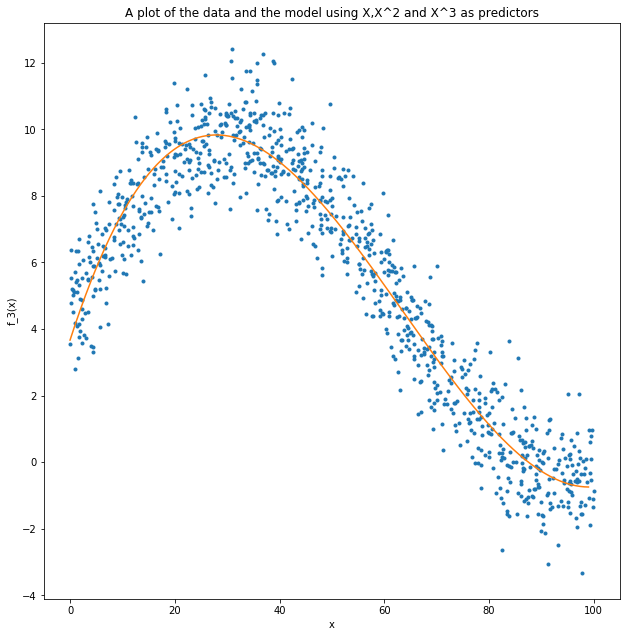

In [32]:
# 1000 linearly spaced numbers
x32 = np.linspace(0,99,1000) 
y32 = lm32.intercept_[0] + lm32.coef_[0][0]*x32 + lm32.coef_[0][1]*x32**2\
    + lm32.coef_[0][2]*x32**3

# Plot the data and the fit
fig = plt.figure(figsize=(8,8))
axes = fig.add_axes([0.1,0.1,1,1])
axes.plot(X,Y_3,'.')
axes.plot(x32,y32)

# Set the lables and title
axes.set_xlabel('x')
axes.set_ylabel('f_3(x)')
axes.set_title('A plot of the data and the model using X,X^2 and X^3 as \
predictors')

plt.show()


We can also check the residuals plot

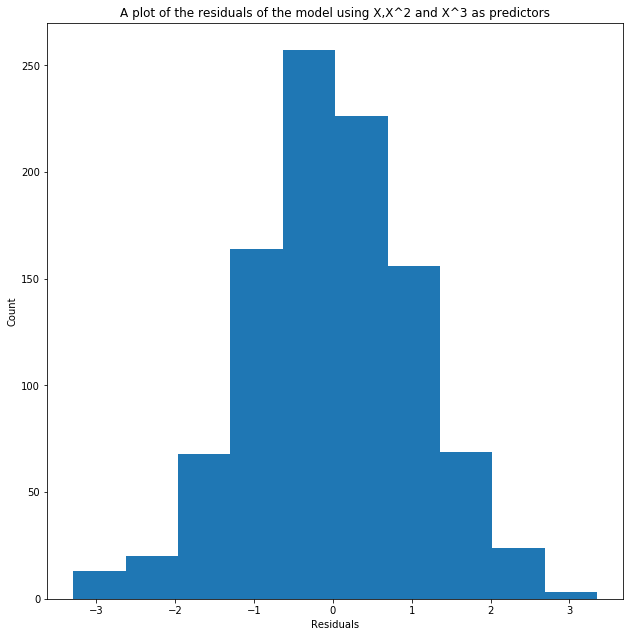

This is roughly a normal distribution with mean -1.765698698363849e-15 and standard deviation 1.043797076853439


In [33]:
# Calculate the fitted values using the observed values
y32_fitted_sklearn = lm32.intercept_[0] + lm32.coef_[0][0]*X + \
                    lm32.coef_[0][1]*X**2 + lm32.coef_[0][2]*X**3

# Calculate the residuals
Res_32 = y32_fitted_sklearn - Y_3

# Plot the residuals
fig = plt.figure(figsize=(8,8))
axes = fig.add_axes([0.1,0.1,1,1])
axes.hist(Res_32)

# Set the lables and title
axes.set_xlabel('Residuals')
axes.set_ylabel('Count')
axes.set_title('A plot of the residuals of the model using X,X^2 and \
X^3 as predictors')

plt.show()

print('This is roughly a normal distribution with mean {mean} and \
standard deviation {std}'.format(mean=np.mean(Res_32),std=np.std(Res_32)))

It is not a surprise that we were able to fit a function of the form $f(x) = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3$. Using taylor expansion, $f(x) = sin(x)$ estimated around the point $x=0$ is

$$f(x=0) = f(0) + f^{(1)}(0)x + f^{(2)}(0)x^2/(2!) + f^{(3)}(0)x^3/(3!) + O(x^4)$$
$$= \sin(0) + \cos(0)x - \sin(0)x^2/(2!) -\cos(0)x^3/(3!)$$
$$= x - x^3/(6)$$

If we apply Taylor series expansion to $f(x) = 4.67 + 5.07 sin(x/20)$ instead:

$$f(x=0) = 4.67 + \frac{5.07}{20}\cos(0)x-\frac{5.07}{20^3}\cos(0)x^3/(3!)=4.67 + 0.25x - 1 \times 10^{-4} x^3$$

Let's plot this along with the above for smaller values of X for which this approximation of sin(x) is acceptable.

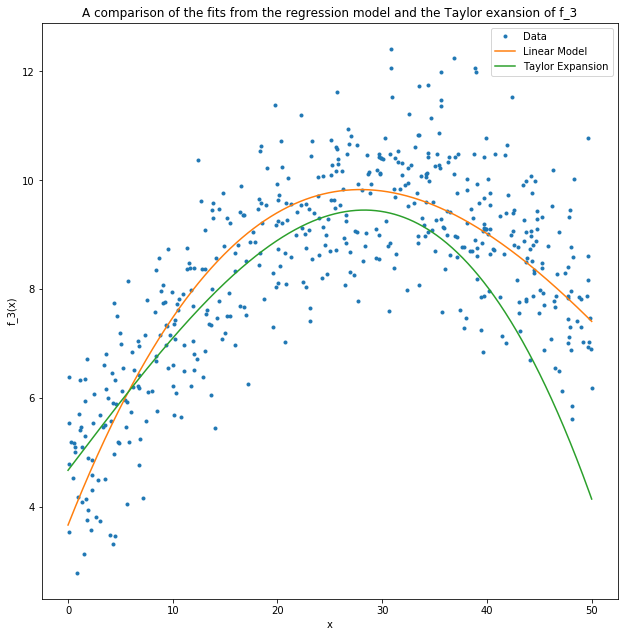

In [34]:
# 1000 linearly spaced numbers
x32 = np.linspace(0,50,1000) 

# Predictions
y32 = lm32.intercept_[0] + lm32.coef_[0][0]*x32 + lm32.coef_[0][1]*x32**2\
    + lm32.coef_[0][2]*x32**3

# Prediction using Taylor expansion
y_taylor_32 = 4.67 + (5.07/20)*x32 + 0*x32**2 - (5.07/(20**3 * 6))*x32**3

# Only get the observed predictors and response where the predictors are less 
# than 50
X_small = list(filter(lambda x: x < 50,X))
Y_small = Y_3[list(map(lambda x: x < 50,X))]

# Plot the data, the fitted model and the taylor expansion
fig = plt.figure(figsize=(8,8))
axes = fig.add_axes([0.1,0.1,1,1])
axes.plot(X_small,Y_small,'.',label='Data')
axes.plot(x32,y32,label='Linear Model')
axes.plot(x32,y_taylor_32,label='Taylor Expansion')

# Set the labels and title
axes.set_xlabel('x')
axes.set_ylabel('f_3(x)')
axes.set_title('A comparison of the fits from the regression model and the \
Taylor exansion of f_3')

# Add the legend
axes.legend()

plt.show()

#### Statistical significance of regression coefficients
In addition to the $R^2$ statistic, it is useful to assess whether a variable is statistically significant. To do this for a variable $X$ with coefficient $\beta_1$, we test the null hypothesis

$$H_O: \beta_1 = 0$$

against

$$H_A: \beta_1 \neq 0$$

For the first model we have the fitted model

In [35]:
print('f(x) = {} + {} X'.format(lm1.intercept_[0],lm1.coef_[0][0]))

f(x) = 5.50124312485309 + 5.064254524922958 X


The standard errors of the estimators $\hat{\beta}_0$ and $\hat{\beta}_1$ for the coefficients have the form (See Appendix A5):

$$SE(\beta_0) = \sqrt{\sigma^2 \left[\frac{1}{n} + \frac{\bar{x}^2}{\sum_{i=1}^n (x_i - \bar{x})^2}\right]} \approx  RSE\sqrt{ \left[\frac{1}{n} + \frac{\bar{x}^2}{\sum_{i=1}^n (x_i - \bar{x})^2}\right]}$$

where RSE is the *residual standard error* estimating the population $\sigma =\sqrt{Var(\epsilon)}$ and has the form $RSE = \sqrt{\frac{\sum_{i=1}^n \epsilon_i^2}{n-2}} = \sqrt{\frac{RSS}{n-2}}$.


In addition we can show that:

$$SE(\beta_1) = \sqrt{   \frac{ \sigma^2 }{ \sum_{i=1}^n (x_i - \bar{x})^2 }   } \approx RSE\sqrt{   \frac{ 1 }{ \sum_{i=1}^n (x_i - \bar{x})^2 }   }$$


Using the standard errors, we can then conduct the hypothesis test above as a t-test. We have that 

$$\frac{ \hat{\beta_0} - \beta_0^{(0)} }{ SE(\beta_0) } \sim t_{n-2}$$

$$\frac{ \hat{\beta_1} - \beta_1^{(0)} }{ SE(\beta_1) } \sim t_{n-2}$$

where $^{(0)}$ denotes the null value (the null hypothesis above sets both $\beta_0^{(0)}=0$ and $\beta_1^{(0)}=0$).

In [36]:
# number of observations n
n = len(X)

# residual standard error
RSE_1 = np.sqrt(RSS_1/(n-2))

# variance of x = sum (x_i - x_bar)^2. Note that this is the 
# population variance calculation
# so we would need to multiply by n
varx_1 = np.var(X)

# mean of x
meanx_1 = np.mean(X)

SE_beta_0 = RSE_1 * np.sqrt(1.0/n + meanx_1**2/(n*varx_1))
SE_beta_1 = RSE_1 * np.sqrt(1.0/(n*varx_1))

print('SE(beta_0) = {}, SE(beta_1) = {}'.format(SE_beta_0,SE_beta_1))

# null hypothesis
betanull_0 = 0
betanull_1 = 0

tstatistic1_0 = (beta1_0 - betanull_0)/SE_beta_0
tstatistic1_1 = (beta1_1 - betanull_1)/SE_beta_1

print('beta_0 t-statistic = {}'.format(tstatistic1_0))
print('beta_1 t-statistic = {}'.format(tstatistic1_1))

# p-value
# the following function calculates the area under the student t pdf with 
# 2 degrees of freedom that is less than -4.303
stats.t.cdf(-4.303,2)

# calculate the p-value using the tstatistic and degrees of freedom n-2
pval1_0 = stats.t.cdf(-tstatistic1_0,n-2)
pval1_1 = stats.t.cdf(-tstatistic1_1,n-2)

print('p-value for beta_0 = {}'.format(pval1_0))
print('p-value for beta_1 = {}'.format(pval1_1))
print('These are both statistically significant!')


SE(beta_0) = 0.6406034056188337, SE(beta_1) = 0.011151051418375258
beta_0 t-statistic = 8.587595814509644
beta_1 t-statistic = 454.150405635995
p-value for beta_0 = 1.685985282508196e-17
p-value for beta_1 = 0.0
These are both statistically significant!


We can put this into a function

In [37]:
def calcpvalue(X,y_observed,y_fitted,beta_0,beta_1,betanull_0,betanull_1):
    '''
    A function to calculate whether the coefficients in a model with 1 
        variable is statistically significant.
    X = a list for the data for the variable
    y_observed = the observed values for the response variable
    y_fitted = the predicted values of the model
    beta_0 = the intercept of the model
    beta_1 = the coefficient of the explanatory variable in the model
    betanull_0 = null hypothesis value for the intercept (usually 0)
    betanull_1 = null hypothesis value for the coefficient of the response 
        variable (usually 0)
    '''
    # number of observations n
    n = len(X)

    # calculate RSS
    temp,RSS = TSS_RSS(y_observed,y_fitted)
    
    # residual standard error
    RSE = np.sqrt(RSS/(n-2))

    # variance of x = sum (x_i - x_bar)^2. Note that this is the population 
    # variance calculation
    # so we would need to multiply by n
    varx = np.var(X)

    # mean of x
    meanx = np.mean(X)

    SE_beta_0 = RSE * np.sqrt(1.0/n + meanx**2/(n*varx))
    SE_beta_1 = RSE * np.sqrt(1.0/(n*varx))

    print('SE(beta_0) = {}, SE(beta_1) = {}'.format(SE_beta_0,SE_beta_1))

    # null hypothesis
    betanull_0 = 0
    betanull_1 = 0

    tstatistic1_0 = (beta_0 - betanull_0)/SE_beta_0
    tstatistic1_1 = (beta_1 - betanull_1)/SE_beta_1

    print('beta_0 t-statistic = {}'.format(tstatistic1_0))
    print('beta_1 t-statistic = {}'.format(tstatistic1_1))

    # p-value

    # calculate the p-value using the tstatistic and degrees of freedom n-2
    # Multiply by 2 since it's a 2 tailed test
    if(tstatistic1_0 > 0):
        pval_0 = stats.t.cdf(-tstatistic1_0,n-2)*2
    else:
        pval_0 = stats.t.cdf(tstatistic1_0,n-2)*2
        
    if(tstatistic1_1 > 0):
        pval_1 = stats.t.cdf(-tstatistic1_1,n-2)*2
    else:
        pval_1 = stats.t.cdf(tstatistic1_1,n-2)*2

    print('p-value for beta_0 = {}'.format(pval_0))
    print('p-value for beta_1 = {}'.format(pval_1))
    if((pval_0 <= 0.05) and (pval_1 <=0.05)):
        print('These are both statistically significant!')
    elif(pval_0 <= 0.05):
        print('Only beta_0 is statistically significant!')
    elif(pval_1 <= 0.05):
        print('Only beta_1 is statistically significant!')
    else:
        print('The parameters of this model are not statistically significant!')

We can do the same calculations for significance for all the models using this function

In [38]:
print('Model for Y_1: Explanatory variable X for Y_1')
calcpvalue(X,Y_1,y1_fitted,beta1_0,beta1_1,0,0)

print()
print()

print('Model for Y_2: Explanatory variable X for Y_2')
calcpvalue(X,Y_2,y2_fitted,beta2_0,beta2_1,0,0)

print()
print()

print('Model for Y_2: Explanatory variable X^2 for Y_2')
calcpvalue(X**2,Y_2,y22_fitted,beta22_0,beta22_1,0,0)

print()
print()

print('Model for Y_3: Explanatory variable X for Y_3')
calcpvalue(X,Y_3,y3_fitted,beta3_0,beta3_1,0,0)

Model for Y_1: Explanatory variable X for Y_1
SE(beta_0) = 0.6406034056188337, SE(beta_1) = 0.011151051418375258
beta_0 t-statistic = 8.587595814509644
beta_1 t-statistic = 454.150405635995
p-value for beta_0 = 3.371970565016392e-17
p-value for beta_1 = 0.0
These are both statistically significant!


Model for Y_2: Explanatory variable X for Y_2
SE(beta_0) = 245.34955295438897, SE(beta_1) = 4.2708256878947495
beta_0 t-statistic = -34.424274285888536
beta_1 t-statistic = 118.51588098729522
p-value for beta_0 = 8.125468707425302e-172
p-value for beta_1 = 0.0
These are both statistically significant!


Model for Y_2: Explanatory variable X^2 for Y_2
SE(beta_0) = 24.614546607361707, SE(beta_1) = 0.005557804748590844
beta_0 t-statistic = 0.5878663289694033
beta_1 t-statistic = 913.1340896074505
p-value for beta_0 = 0.5567550098751695
p-value for beta_1 = 0.0
Only beta_1 is statistically significant!


Model for Y_3: Explanatory variable X for Y_3
SE(beta_0) = 0.15212372264589394, SE(beta_1)

We can use the statsmodels.api to verify our results

In [39]:
print('Model for Y_1: Explanatory variable X for Y_1')

# add a column of ones to X
X_new = sm.add_constant(X)

# ordinary least squares approach to optimisation
est = sm.OLS(Y_1, X_new)

# fit the data to the model using OLS
est2 = est.fit()

# print a summary of the model
print(est2.summary())

print()
print()

#re-run the above for all the models

print('Model for Y_2: Explanatory variable X for Y_2')
X_new = sm.add_constant(X)
est = sm.OLS(Y_2, X_new)
est2 = est.fit()
print(est2.summary())

print()
print()

print('Model for Y_2: Explanatory variable X^2 for Y_2')
X_new = sm.add_constant(X**2)
est = sm.OLS(Y_2, X_new)
est2 = est.fit()
print(est2.summary())

print()
print()

print('Model for Y_3: Explanatory variable X for Y_3')
X_new = sm.add_constant(X)
est = sm.OLS(Y_3, X_new)
est2 = est.fit()
print(est2.summary())

print()
print()

print('Model for Y_3: Explanatory variables X,X^2,X^3 for Y_3')
# concatenate multiple variables
X_new = sm.add_constant(pd.concat([pd.DataFrame(X,columns=['X']),\
                                   pd.DataFrame(X**2,columns=['X2']),\
                                   pd.DataFrame(X**3,columns=['X3'])],axis=1))
est = sm.OLS(Y_3, X_new)
est2 = est.fit()
print(est2.summary())

Model for Y_1: Explanatory variable X for Y_1
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 2.063e+05
Date:                Tue, 16 Jul 2019   Prob (F-statistic):               0.00
Time:                        07:37:17   Log-Likelihood:                -3730.1
No. Observations:                1000   AIC:                             7464.
Df Residuals:                     998   BIC:                             7474.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

It looks like the intercept for *Model for Y_2: Explanatory variable X^2 for Y_2* is not statistically significant. The intercept can then be omitted from the model and fitted again.

In [40]:
print('Model for Y_2: Explanatory variable X^2 for Y_2')
est = sm.OLS(Y_2, X**2)
est2 = est.fit()
print(est2.summary())

Model for Y_2: Explanatory variable X^2 for Y_2
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.878e+06
Date:                Tue, 16 Jul 2019   Prob (F-statistic):               0.00
Time:                        07:37:17   Log-Likelihood:                -7670.2
No. Observations:                1000   AIC:                         1.534e+04
Df Residuals:                     999   BIC:                         1.535e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1  

This is a good fit also

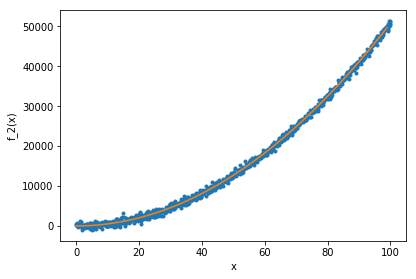

In [41]:
x23 = np.linspace(0,99,1000) # 1000 linearly spaced numbers
y23 = est2.params[0] * x23**2

fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(X,Y_2,'.')
axes.set_xlabel('x')
axes.set_ylabel('f_2(x)')
axes.plot(x23,y23)

If we set $\beta_0=0$ in the derivation for $\hat{\beta_0}$ and $\hat{\beta_1}$ earlier in the article, we would have obtained the equation

$$\hat{\beta_1} = \frac{\sum_{i=1}^n y_i x_i}{\sum_{i=1}^n x_i^2}$$

Using this equation, we can reproduce the statsmodels solution above. Note that removing $\beta_0$ has changed $\beta_1$ slightly:

In [42]:
# remember that we are fitting the variable X^2
sum1 = np.sum(Y_2*X**2)
sum2 = np.sum(X**4)

beta23_1 = sum1/sum2

print('Y ~ {} X^2'.format(beta23_1))

Y ~ 5.077455649665152 X^2


#### F-Statistic

The F-Statistic answers the question 'Is there evidence that at least one of the explanatory variables is related to the response variable?'. This corresponds to a hypothesis test with:

$$H_O: \beta_0, \beta_1, ..., \beta_p = 0$$
$$H_A: \text{at least one of } \beta_i \text{ is non-zero}$$

The F-Statistic has the form:

$$F = \frac{(TSS - RSS)/p}{RSS/(n-p-1)}$$

where p is the number of explanatory variables/parameters. 

If $H_O$ is not true, the numerator in the above equation becomes larger, i.e. F > 1. If $H_0$ is true, then the F-Statistic is close to 1.

(PROOF of this - take expectation of numerator and denominator and these are both equal to Var($\epsilon$). If $H_A$ is true then the numerator > Var($\epsilon$))

We can use this to calculate the F-Statistics of the above models:

In [43]:
def FStat(n,p,TSS,RSS):
    F = ((TSS-RSS)/p)/(RSS/(n-p-1))
    print('The F-Statistic is {}'.format(F))

In [44]:
# we didn't calculate the last model ourselves, we used sklearn 
# so we retrieve the coefficients
beta32_0 = lm32.intercept_[0]
beta32_1 = lm32.coef_[0][0]
beta32_2 = lm32.coef_[0][1]
beta32_3 = lm32.coef_[0][2]

In [45]:
print('Model for Y_1: Explanatory variable X for Y_1')
FStat(len(X),1,TSS_1,RSS_1)

print()
print()

#re-run the above for all the models

print('Model for Y_2: Explanatory variable X for Y_2')
FStat(len(X),1,TSS_2,RSS_2)

print()
print()

print('Model for Y_2: Explanatory variable X^2 for Y_2')
FStat(len(X),1,TSS_22,RSS_22)

print()
print()

print('Model for Y_3: Explanatory variable X for Y_3')
FStat(len(X),1,TSS_3,RSS_3)

print()
print()

TSS_32,RSS_32 = TSS_RSS(Y_3,y32_fitted_sklearn)

print('Model for Y_3: Explanatory variables X,X^2,X^3 for Y_3')
# now we have 3 explanatory variables
FStat(len(X),3,TSS_32,RSS_32)

Model for Y_1: Explanatory variable X for Y_1
The F-Statistic is 206252.59093933867


Model for Y_2: Explanatory variable X for Y_2
The F-Statistic is 14046.014046194661


Model for Y_2: Explanatory variable X^2 for Y_2
The F-Statistic is 833813.8656032282


Model for Y_3: Explanatory variable X for Y_3
The F-Statistic is 1460.506619784441


Model for Y_3: Explanatory variables X,X^2,X^3 for Y_3
The F-Statistic is 3974.1603226694606


These match the *statsmodels* outputs. We can also find the p-value of a coefficient/intercept using the F-Statistic. The F-Statistic formula becomes:

$$F = \frac{(RSS_0 - RSS)/q}{RSS/(n-p-1)}$$

where $RSS_0$ is the residual sum of squares for the model with $q$ removed parameters. The corresponding hypothesis test is then

$$H_0: \{ \beta_i = 0 \} \text{ where i takes on the q removed parameters}$$
$$H_A: \text{at least one of those q parameters is non-zero}$$

Above, we ran a model for Y_2 which had an intercept, coefficient of X^2 and RSS of:

In [46]:
beta22_0, beta22_1, RSS_22

(14.470063153316005, 5.075020979320466, 268902718.6114595)

Here, we are going to calculate the p-value of the intercept for Y_2 when we try to fit an intercept as well as $X^2$. We do this by first fitting the full model including the intercept and getting the RSS value, then we fit the model without the intercept and get the RSS value. The Coefficient of X^2 and RSS for the model without the intercept was calculated to be

In [47]:
TSS_23,RSS_23 = TSS_RSS(Y_2,beta23_1 * X**2)
print('beta_1 = {}, RSS_0 = {}'.format(beta23_1,RSS_23))

beta_1 = 5.077455649665152, RSS_0 = 268995834.0780044


We now create a function to apply the formula shown above for calculating the F-Statistic for comparing models

In [48]:
def FStatCompare(n,p,q,RSS0,RSS):
    '''
    A function to calculate the F-Statistic when we are comparing models 
        with different number of parameters.
    RSS0 is a sub-model of RSS
    '''
    F = ((RSS0-RSS)/q)/(RSS/(n-p-1))
    print('The F-Statistic is {}'.format(F))
    return F

Now we can confirm the p-value for the intercept

In [49]:
# This is the fitted values for the model with no intercept
Y23_fitted = beta23_1 * X**2

# These are the TSS and RSS for this model with no intercept
TSS_2_test,RSS_2_test = TSS_RSS(Y_2,Y23_fitted)

# RSS_22 is the RSS for the model with the intercept. RSS_23 is the RSS
# for the model without the intercept. We have p = 0 and q = 1 (i.e. we have 
# removed 1 parameter but there was only 1 parameter to begin with)
F = FStatCompare(len(X),0,1,RSS_23,RSS_22)

# the following function calculates the area underneath the cdf F-distribution 
# with dfn(degrees of freedom in the numerator)=1, 
# dfd(degrees of freedom in the denominator)=len(X)-2 less than 0.5
stats.f.cdf(0.5,1,len(X)-2)

print('The p-value of the intercept is {}'.format(1-stats.f.cdf(F,1,len(X)-2)))

The F-Statistic is 0.3459331001141355
The p-value of the intercept is 0.5565574505496756


Note that above, we removed the intercept and used the F-Statistic to calculate the p-value for the intercept. We can also remove the coefficient of X^2 and calculate the p-value of this coefficient using the same procedure as above. First fit the model as we have done before

In [50]:
lmOnlyIntercept = LinearRegression()
lmOnlyIntercept.fit((X*0).reshape(-1,1),Y_2.reshape(-1,1))
print('Model for Y_2: No explanatory variable for Y_2')
print('beta_0 = {}'.format(lmOnlyIntercept.intercept_[0]))
yOnlyIntercept_fitted_sklearn = lmOnlyIntercept.intercept_[0] + X*0
print('R^2 = {}'.format(r2_score(Y_2,yOnlyIntercept_fitted_sklearn)))

Model for Y_2: No explanatory variable for Y_2
beta_0 = 16763.308428792458
R^2 = 0.0


Next, calculate the RSS for this model we have just fitted

In [51]:
TSS_OnlyIntercept,RSS_OnlyIntercept = TSS_RSS(Y_2,yOnlyIntercept_fitted_sklearn)
print('beta_0 = {}, RSS_0 = {}'.format(lmOnlyIntercept.intercept_[0],\
                                       RSS_OnlyIntercept))

beta_0 = 16763.308428792458, RSS_0 = 224933046282.3772


And now we calculate the p-value of the coefficient of X^2

In [52]:
# These are the TSS and RSS for this model with only intercept
TSS_2_test,RSS_2_test = TSS_RSS(Y_2,yOnlyIntercept_fitted_sklearn)

# RSS_22 is the RSS for the model with the intercept. RSS_23 is the RSS
# for the model without the intercept. We have p = 0 and q = 1 (i.e. we have 
# removed 1 parameter but there was only 1 parameter to begin with)
F = FStatCompare(len(X),0,1,RSS_2_test,RSS_22)

# the following function calculates the area underneath the cdf F-distribution 
# with dfn(degrees of freedom in the numerator)=1, 
# dfd(degrees of freedom in the denominator)=len(X)-2 less than 0.5
stats.f.cdf(0.5,1,len(X)-2)

print('The p-value of the X^2 coefficient is {}'\
      .format(1-stats.f.cdf(F,1,len(X)-2)))

The F-Statistic is 834649.3504385022
The p-value of the X^2 coefficient is 1.1102230246251565e-16


### Synergy Effect

Suppose we have the following function

$$f(x)=4.67+2*X_1+3*X_2+5.07∗X_1*X_2$$

We can see that there is a mixed term '$X_1 X_2$'. This is called a synergy effect.

Let's define this function and plot it

Text(0, 0.5, 'f(x)')

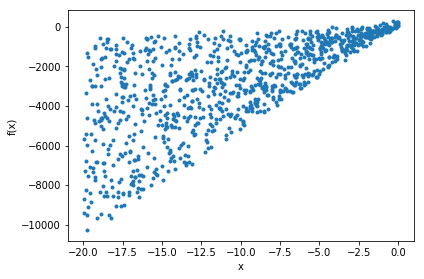

In [53]:
# We will need to plot in 3D
from mpl_toolkits.mplot3d import Axes3D

#f(x)=4.67+2*X_1+30*X_2+5.07∗X_1*X_2
def f(x1,x2):
    return 4.67+2*x1+30*x2+5.07*x1*x2
# Set the seed
r = np.random.RandomState(101)
X_1 = 100*r.rand(1000)
X_2 = -20*r.rand(1000)

#Error term with sigma = 10, mu = 0
E = 100*r.randn(1000)

#Response variables
Y = list(map(f,X_1,X_2))+E

fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(X_2,Y,'.')
axes.set_xlabel('x')
axes.set_ylabel('f(x)')

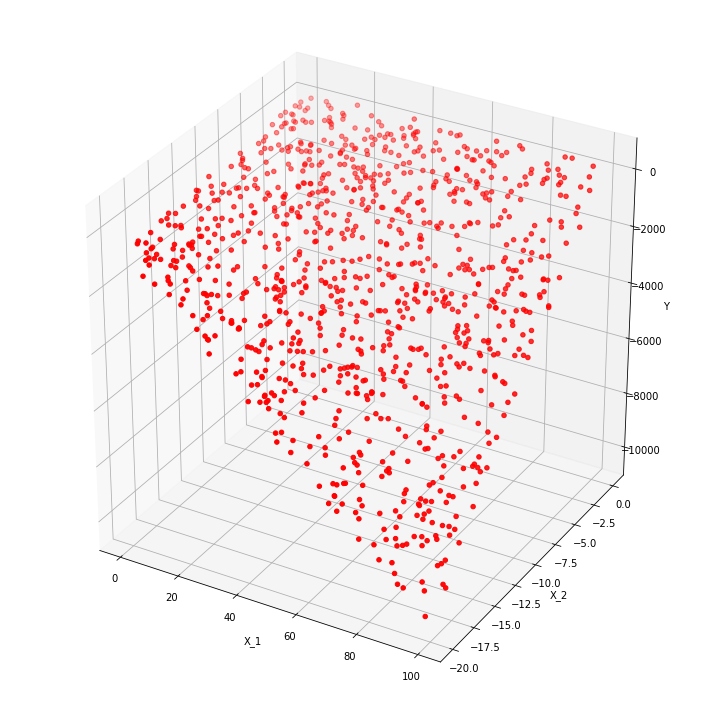

In [54]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_1, X_2, Y, c='r', marker='o')

ax.set_xlabel('X_1')
ax.set_ylabel('X_2')
ax.set_zlabel('Y')

plt.tight_layout()

Suppose we continued to fit a linear regression model with parameters $X_1$ and $X_2$ with the assumption that there is no synergy effect.

In [55]:
print('Model for Y: Explanatory variable X_1 and X_2 for Y')
X_new = sm.add_constant(pd.concat([pd.DataFrame(X_1,columns=['X_1']),\
                                   pd.DataFrame(X_2,columns=['X_2'])],axis=1))
est = sm.OLS(Y, X_new)
est2 = est.fit()
print(est2.summary())

Model for Y: Explanatory variable X_1 and X_2 for Y
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     3169.
Date:                Tue, 16 Jul 2019   Prob (F-statistic):               0.00
Time:                        07:37:18   Log-Likelihood:                -8160.3
No. Observations:                1000   AIC:                         1.633e+04
Df Residuals:                     997   BIC:                         1.634e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


The above output shows that the $R^2$ is almost 87% with both $X_1$ and $X_2$ being statistically significant. Below, we show that including the synergy term $X_1 X_2$ into the model as well greatly improves the $R^2$ metric.

In [56]:
print('Model for f: Explanatory variables X_1, X_2 and X_1 * X_2 for Y_2')
X_new = sm.add_constant(pd.concat([pd.DataFrame(X_1,columns=['X_1']),\
                                   pd.DataFrame(X_2,columns=['X_2']),\
                                   pd.DataFrame(X_1*X_2,columns=['X_12'])],axis=1))
est = sm.OLS(Y, X_new)
est2 = est.fit()
print(est2.summary())

Model for f: Explanatory variables X_1, X_2 and X_1 * X_2 for Y_2
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.651e+05
Date:                Tue, 16 Jul 2019   Prob (F-statistic):               0.00
Time:                        07:37:18   Log-Likelihood:                -6052.5
No. Observations:                1000   AIC:                         1.211e+04
Df Residuals:                     996   BIC:                         1.213e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

We have seen above that adding a term $X_1 X_2$ significantly increased the $R^2$ statistic. Instead of adding this joint term, what would be the effect on $R^2$ if we added random noise? We see the effect below.

In [57]:
# Set the seed
r = np.random.RandomState(11)

#Error term with sigma = 10, mu = 0
noise = 100*r.randn(1000)

print('Model for Y: Explanatory variable X_1 and X_2 for Y')
X_new = sm.add_constant(pd.concat([pd.DataFrame(X_1,columns=['X_1']),\
                                   pd.DataFrame(X_2,columns=['X_2']),\
                                  pd.DataFrame(noise,columns=['Noise'])],axis=1))
est = sm.OLS(Y, X_new)
est2 = est.fit()
print(est2.summary())

Model for Y: Explanatory variable X_1 and X_2 for Y
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     2123.
Date:                Tue, 16 Jul 2019   Prob (F-statistic):               0.00
Time:                        07:37:18   Log-Likelihood:                -8157.8
No. Observations:                1000   AIC:                         1.632e+04
Df Residuals:                     996   BIC:                         1.634e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


Including an unrelated, random noise term to the model increases the $R^2$ statistic. This makes sense since when fitting the model to the training data, in the worst case, the model could choose a predictor's coefficient to be zero. This means that the $R^2$ statistic for the training data should never decrease as a function of the number of predictors. The main reason for introducing such a metric is to gauge how well the model describes the population from which our data originates from. However, if it never decreases then how can it be determined whether the added parameter is useful or not? 

In order to cater for this, the Adjusted $R^2$ metric can be used. This metric applies a penalty to the usual $R^2$ the more predictors that are used. This way, it is not possible that the Adjusted $R^2$ can increase indefinitely. At some point, the contribution to the $R^2$ of adding a new predictor will be overcome by the penalty attributed to adding that new parameter. The Adjusted $R^2$ is as follows:

$$ \text{Adjusted }R^2 = 1 - \frac{ RSS/(n - p - 1) }{ TSS/(n - 1) } $$

where $p$ is the number of predictors. It can be seen in the above model that the Adjusted $R^2$ did not increase with the addition of another predictor.

Another approach we can apply to take into account that the test $R^2$ will always be smaller than the training $R^2$, is to divide the data we have into a training set and a testing set. We can then train the model on the training set and test it on the unseen testing set in order to determine how well it has performed.

We tackle this in the next section.

### Cross Validation



*Cross Validation* is a technique to estimate how well a model will perform on unseen data. As mentioned in the previous section, the entire data set available can be divided into two: a training set and a testing set. The question then becomes, 'what portion of the dataset should be the training set?'. This question can be expressed as follows:

- Let the number of observations be $n$, then the trainnig set is $n-k$ where $k \in [1,n-1]$

The reason this question is important is that the choice of $k$ greatly influences the bias in our cross validation. If $k = \lfloor n/2 \rfloor$ then the test error will be greatly overestimated since the final model will be trained on $n$ observations, not $\lfloor n/2 \rfloor$ observations. On the other hand, if $k=1$, the variance of our test error will be very large since the technique will depend greatly on which observation we chose as the test observation. 

Going further, we can divide the entire dataset into roughly $n/k$ subsets. We can then run $n/k$ different cross validations leaving a different subset as the test set at each iteration. The test error (or $R^2$) can then be approximated as the average of the different subset test errors. This immediately means that if $n$ is large, choosing to assess the model performance using cross validation with $k=1$ could be computationally intense. Therefore, a value for $k$ somewhere in the range $(1,\lfloor n/2 \rfloor)$ may be wiser.

To start things off, let's fit a linear regression model to the house prices dataset and test it on a portion of the data.

In [58]:
housePrice.columns

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

We use train test split (using 33% of the dataset as a test set) to calculate the MSE on the test set

The MSE is [5.29577792e+09]


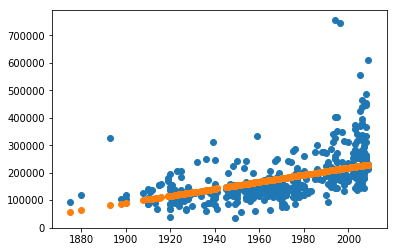

In [59]:
# The predictor and response
X = housePrice['YearBuilt'].values.reshape(-1,1)
y = housePrice['SalePrice'].values.reshape(-1,1)

# Make 33% of this dataset a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Linear Regression model object
model = LinearRegression()

# Fit this model using the training data
model.fit(X_train,y_train)

# Predict
predictions = model.predict(X_test)

# Get the RSS
tss,rss = TSS_RSS(y_test,predictions)

# The MSE is RSS/n_test
MSE = rss/len(y_test)

print('The MSE is {}'.format(MSE))

# Plot the predictions
plt.scatter(X_test,y_test)
plt.scatter(X_test,predictions)

Let's see what the MSE is when we use the 'LotArea' predictor to predict 'SalePrice'.

The MSE is [6.89081973e+09]


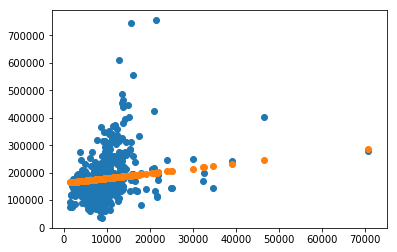

In [60]:
# The predictor and response
X = housePrice['LotArea'].values.reshape(-1,1)
y = housePrice['SalePrice'].values.reshape(-1,1)

# Make 33% of this dataset a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Linear Regression model object
model = LinearRegression()

# Fit this model using the training data
model.fit(X_train,y_train)

# Predict
predictions = model.predict(X_test)

# Get the RSS
tss,rss = TSS_RSS(y_test,predictions)

# The MSE is RSS/n_test
MSE = rss/len(y_test)

print('The MSE is {}'.format(MSE))

# Plot the predictions
plt.scatter(X_test,y_test)
plt.scatter(X_test,predictions)

An important point to note in the above MSE calculations is that these MSE results are highly biased. We used a train - test split of 33%. However, in reality, we have the full dataset to train our model on. This means that the above is overestimating the test MSE of the model. In other words, by using only a subset of our dataset to train our model, we are not making use of the full power of the data we have. We can go to the other extreme and select one single observation from our data set of n observations as a test set and the remaining n-1 observations as a training set. This is called Leave One Out Cross Validation (LOOCV). We do that below.

MSE = [5136706.28774715]


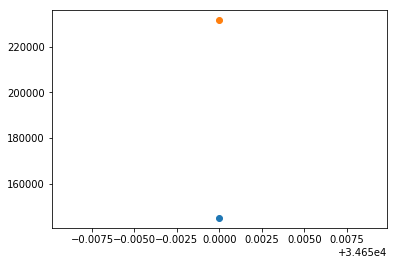

In [61]:
# The predictor and response
X = housePrice['LotArea']
y = housePrice['SalePrice']

# Select a random element to be the test set
r = random.SystemRandom()
testint = r.randint(0,len(X))

# The train set
X_train = X.copy().values.reshape(-1,1)
y_train = y.copy().values.reshape(-1,1)

# The test set is that one observation
X_test = X_train[testint]
X_test = X_test.reshape(1,-1)

# The train set is all observations except that one observation
np.delete(X_train,testint)

# The test set consist of one response
y_test = y_train[testint]
np.delete(y_train,testint)

# The Linear Regression model object
model = LinearRegression()

# Fit the model
model.fit(X_train,y_train)

# Predict
predictions = model.predict(X_test)

# Get the MSE. MSE = RSS/n
tss,rss = TSS_RSS(y_test,predictions)
MSE = rss/len(y)
print('MSE = {}'.format(MSE))

# Plot
plt.scatter(X_test,y_test)
plt.scatter(X_test,predictions)

Each time we run the above code, we get a completely different test MSE. This is because the test MSE depends on which observation we chose to test the model on. So this reduces the bias to a minimum but has a large variance. We can iterate over all the cases where for each iteration we leave a different observation as a test observation. Then we calculate the average MSE over all these Cross Validations.

First for 'YearBuilt' as a predictor variable then the 'LotArea' as a predictor variable.

In [62]:
# The predictor and response
X = housePrice['YearBuilt']
y = housePrice['SalePrice']

# The MSE array. Each element is the MSE of a particular Cross Validation
MSE = []

# Perform LOOCV on the data using Linear Regression
for i in range(len(X)):
    # The training set
    X_train = X.copy().values.reshape(-1,1)
    y_train = y.copy().values.reshape(-1,1)
    
    # The test set is a single observation
    X_test = X_train[i]
    X_test = X_test.reshape(1,-1)
    X_train = np.delete(X_train,i)

    # The test set is a single observation
    y_test = y_train[i]
    y_test = y_test.reshape(1,-1)
    y_train = np.delete(y_train,i)

    # Train the model
    model = LinearRegression()

    # Fit
    model.fit(X_train.reshape(-1,1),y_train.reshape(-1,1))

    # Predict
    predictions = model.predict(X_test)

    # Calculate the MSE. MSE = RSS/n_test
    tss,rss = TSS_RSS(y_test,predictions)
    MSE.append(rss[0])

# Print the mean MSE value
print(np.mean(MSE))

4597328547.297891


In [63]:
X = housePrice['LotArea']
y = housePrice['SalePrice']

MSE = []

for i in range(len(X)):
    X_train = X.copy().values.reshape(-1,1)
    y_train = y.copy().values.reshape(-1,1)
    
    X_test = X_train[i]
    X_test = X_test.reshape(1,-1)
    X_train = np.delete(X_train,i)

    y_test = y_train[i]
    y_test = y_test.reshape(1,-1)
    y_train = np.delete(y_train,i)

    # Train
    model = LinearRegression()

    # Fit
    model.fit(X_train.reshape(-1,1),y_train.reshape(-1,1))

    # Predict
    predictions = model.predict(X_test)

    # MSE
    tss,rss = TSS_RSS(y_test,predictions)
    MSE.append(rss[0])

print(np.mean(MSE))

5954196196.345752


We can leverage the cross_val_score method to do the above cross validation for us

In [64]:
X = housePrice['LotArea']
y = housePrice['SalePrice']

linregCVScores = cross_val_score(LinearRegression(),X.values.reshape(-1,1),y.values.reshape(-1,1),scoring='neg_mean_squared_error',cv=len(X))
-linregCVScores.mean()

5954196196.345752

Let's observe now which approach (value of k in k-fold cross validation) predicts the test MSE best. We split our train and test data. Then estimate the test MSE using the training data.

Step = 0
Step = 50
Step = 100
Step = 150
Step = 200
Step = 250
Step = 300
Step = 350
Step = 400
Step = 450
The mean MSE Estimation using K-fold CV with k = 10 is : 6170090398.833329
The mean MSE Estimation using K-fold CV with k = 20 is : 6161875851.874799
The mean MSE Estimation using K-fold CV with k = 100 is : 6146620803.335432
The actual MSE on this data set is : 6046571007.118181


Text(0.5, 1.0, 'Averaged Actual MSE over different train/test splits')

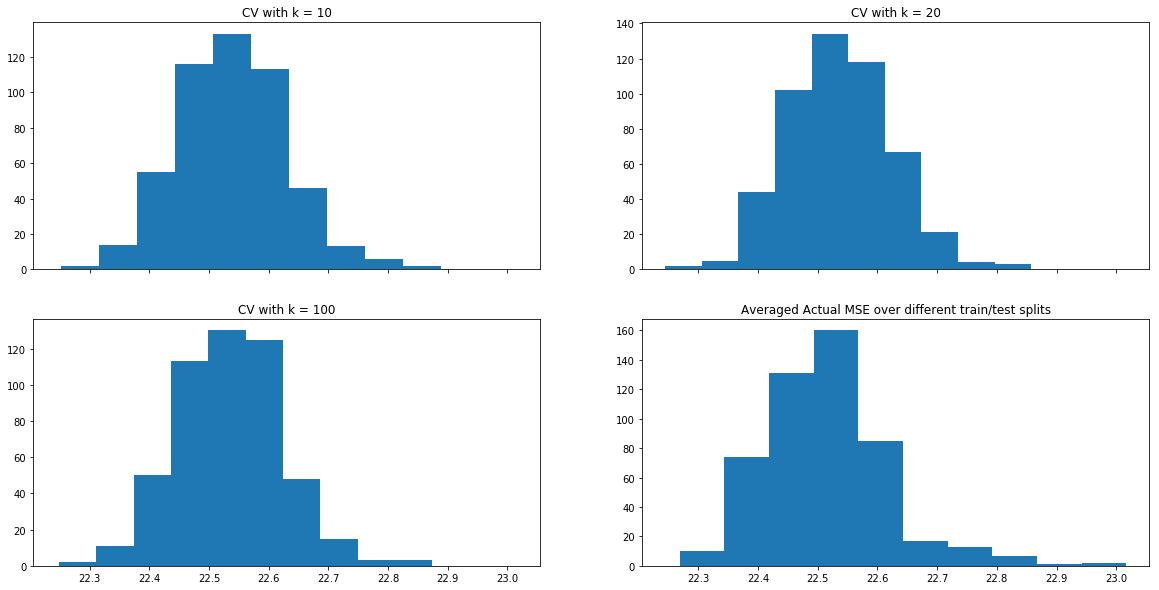

In [65]:
datasetMSEEstimatek_10 = []
datasetMSEEstimatek_20 = []
datasetMSEEstimatek_100 = []
datasetMSEActual = []

# The predictor and response
X = housePrice['LotArea'].values.reshape(-1,1)
y = housePrice['SalePrice'].values.reshape(-1,1)


for j in range(500):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=j)

    linregCVScores = cross_val_score(LinearRegression(),X_train.reshape(-1,1),y_train.reshape(-1,1),scoring='neg_mean_squared_error',cv=10)
    datasetMSEEstimatek_10.append(-linregCVScores.mean())
    
    linregCVScores = cross_val_score(LinearRegression(),X_train.reshape(-1,1),y_train.reshape(-1,1),scoring='neg_mean_squared_error',cv=20)
    datasetMSEEstimatek_20.append(-linregCVScores.mean())
    
    linregCVScores = cross_val_score(LinearRegression(),X_train.reshape(-1,1),y_train.reshape(-1,1),scoring='neg_mean_squared_error',cv=100)
    datasetMSEEstimatek_100.append(-linregCVScores.mean())
    
    
    model = LinearRegression()
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    datasetMSEActual.append(mean_squared_error(y_test,predictions))
    
    if j%50 == 0:
        print('Step = {}'.format(j))
    
print('The mean MSE Estimation using K-fold CV with k = 10 is : {}'.format(np.mean(datasetMSEEstimatek_10)))
print('The mean MSE Estimation using K-fold CV with k = 20 is : {}'.format(np.mean(datasetMSEEstimatek_20)))
print('The mean MSE Estimation using K-fold CV with k = 100 is : {}'.format(np.mean(datasetMSEEstimatek_100)))
print('The actual MSE on this data set is : {}'.format(np.mean(datasetMSEActual)))

fig,axes = plt.subplots(nrows = 2,ncols = 2,sharex=True)
fig.set_size_inches(20,10)

axes[0][0].hist(list(map(math.log,datasetMSEEstimatek_10)))
axes[0][0].set_title('CV with k = 10')

axes[0][1].hist(list(map(math.log,datasetMSEEstimatek_20)))
axes[0][1].set_title('CV with k = 20')

axes[1][0].hist(list(map(math.log,datasetMSEEstimatek_100)))
axes[1][0].set_title('CV with k = 100')

axes[1][1].hist(list(map(math.log,datasetMSEActual)))
axes[1][1].set_title('Averaged Actual MSE over different train/test splits')

Step = 0
Step = 50
Step = 100
Step = 150
Step = 200
Step = 250
Step = 300
Step = 350
Step = 400
Step = 450
The mean MSE Estimation using K-fold CV with k = 10 is : 4622083078.925203
The mean MSE Estimation using K-fold CV with k = 20 is : 4621267854.562423
The mean MSE Estimation using K-fold CV with k = 100 is : 4620965999.249676
The actual MSE on this data set is : 4587675012.9899845


Text(0.5, 1.0, 'Averaged Actual MSE over different train/test splits')

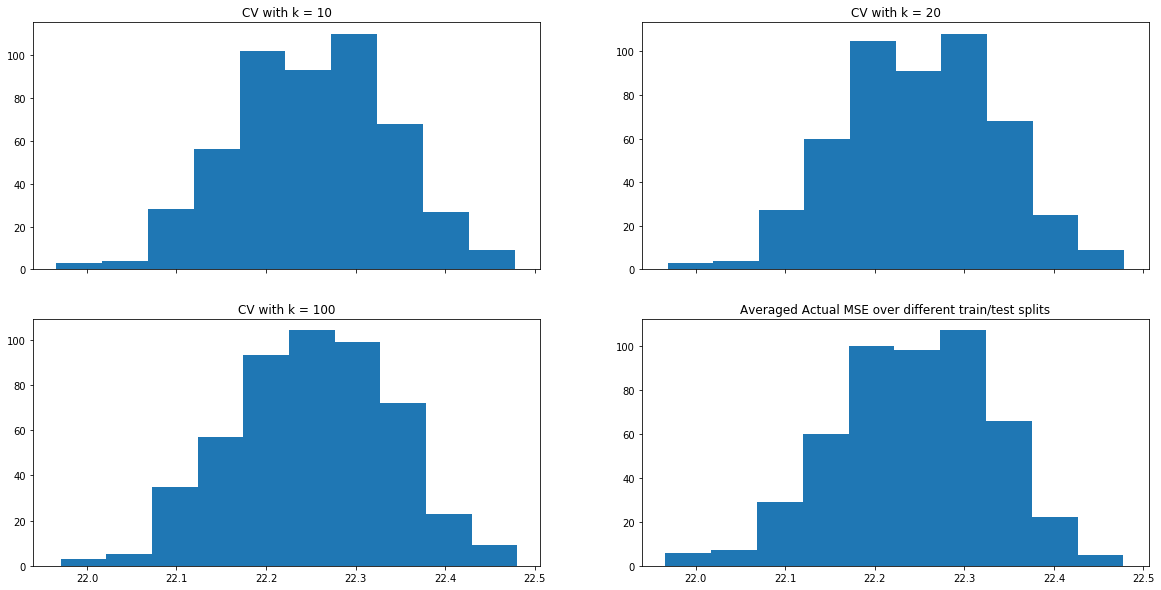

In [66]:
datasetMSEEstimatek_10 = []
datasetMSEEstimatek_20 = []
datasetMSEEstimatek_100 = []
datasetMSEActual = []

# The predictor and response
X = housePrice['YearBuilt'].values.reshape(-1,1)
y = housePrice['SalePrice'].values.reshape(-1,1)


for j in range(500):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=j)

    linregCVScores = cross_val_score(LinearRegression(),X_train.reshape(-1,1),y_train.reshape(-1,1),scoring='neg_mean_squared_error',cv=10)
    datasetMSEEstimatek_10.append(-linregCVScores.mean())
    
    linregCVScores = cross_val_score(LinearRegression(),X_train.reshape(-1,1),y_train.reshape(-1,1),scoring='neg_mean_squared_error',cv=20)
    datasetMSEEstimatek_20.append(-linregCVScores.mean())
    
    linregCVScores = cross_val_score(LinearRegression(),X_train.reshape(-1,1),y_train.reshape(-1,1),scoring='neg_mean_squared_error',cv=100)
    datasetMSEEstimatek_100.append(-linregCVScores.mean())
    
    
    model = LinearRegression()
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    datasetMSEActual.append(mean_squared_error(y_test,predictions))
    
    if j%50 == 0:
        print('Step = {}'.format(j))
    
print('The mean MSE Estimation using K-fold CV with k = 10 is : {}'.format(np.mean(datasetMSEEstimatek_10)))
print('The mean MSE Estimation using K-fold CV with k = 20 is : {}'.format(np.mean(datasetMSEEstimatek_20)))
print('The mean MSE Estimation using K-fold CV with k = 100 is : {}'.format(np.mean(datasetMSEEstimatek_100)))
print('The actual MSE on this data set is : {}'.format(np.mean(datasetMSEActual)))

fig,axes = plt.subplots(nrows = 2,ncols = 2,sharex=True)
fig.set_size_inches(20,10)

axes[0][0].hist(list(map(math.log,datasetMSEEstimatek_10)))
axes[0][0].set_title('CV with k = 10')

axes[0][1].hist(list(map(math.log,datasetMSEEstimatek_20)))
axes[0][1].set_title('CV with k = 20')

axes[1][0].hist(list(map(math.log,datasetMSEEstimatek_100)))
axes[1][0].set_title('CV with k = 100')

axes[1][1].hist(list(map(math.log,datasetMSEActual)))
axes[1][1].set_title('Averaged Actual MSE over different train/test splits')

We can see above that the MSE when we choose the 'LotArea' predictor is not as good as using 'YearBuilt'. So in this case we choose 'YearBuilt' over 'LotArea' to include in our linear regression model. 

It can be seen that there is a general pattern in the above when comparing the MSE estimates from varying blocks (k) in Cross Validation. Namely, the larger k is, the more blocks we use to split the data up and the less portion of the data there is for the test set and the more iteration that is required per Cross Validation. For example, suppose n = 1000, when k = 10 we have 10 blocks with 100 observations per block. So we fit the model 10 times, each time leaving out a different k block when training. When comparing this with the case where k = 100, we have 100 blocks each with 10 observations. This means that the training set for each of these model fits is a lot closer to reality in that we will be using the entire dataset to fit the model. However, this comes at a computational cost, in this case we would need to run a model to fit and predict 100 times instead of 10. 

Depending on the computational cost of the model used, we may choose a smaller value of k = 10 when comparing the same model but with different parameters. 

We can try out all the predictors and choose the one that minimises the mean squared errors. This can be done by using a loop as below.

In [67]:
# Run through each model in the correct order and run CV on it and save the best CV score
bestMeanCV = -1
bestMeanCVModel = []

X = housePrice.drop('SalePrice',axis=1)

# y is the response variable
y = housePrice['SalePrice']

for i in X.columns:
    # First set X to be the full set of remaining parameters
    X = housePrice.loc[:,i]
    
    linregCVScores = cross_val_score(LinearRegression(),X.values.reshape(-1,1),y,scoring='neg_mean_squared_error',cv=10)
    
    if bestMeanCV > -linregCVScores.mean():
        bestMeanCV = -linregCVScores.mean()
        bestMeanCVModel = i
    elif bestMeanCV == -1:
        bestMeanCV = -linregCVScores.mean()
        bestMeanCVModel = i
        
print('The final best model is {} and its TEST MSE is {}'.format(bestMeanCVModel,bestMeanCV))

The final best model is OverallQual and its TEST MSE is 2371260934.069027


We can then iterate through the predictors adding it to the model each time in order to improve the test MSE of the model. For instance, in the above, we have selected as the first predictor in our model, the predictor 'OverallQual'. Next, we cycle through all the remaining predictors to include in our model along with 'OverallQual' and repeat. The final result will be a list of all predictors in the order they were added. Once we get to a point where adding another predictor to the model does not improve the test MSE, then we stop there.

In [68]:
# Run through each model in the correct order and run CV on it and save the best CV score
bestMeanCV = -1
bestMeanCVModel = []
oldArraySize = 0

X = housePrice.drop('SalePrice',axis=1)

columnsArray = X.columns

# y is the response variable
y = housePrice['SalePrice']

while oldArraySize != len(X):
    bestPredictor = ''
    oldArraySize = len(X.columns)
    for i in columnsArray:
        thisModel = bestMeanCVModel.copy()
        thisModel.append(i)
        # First set X to be the full set of remaining parameters
        x = X.loc[:,thisModel]

        if len(x.columns) == 1:
            linregCVScores = cross_val_score(LinearRegression(),x.values.reshape(-1,1),y,scoring='neg_mean_squared_error',cv=10)
        else:
            linregCVScores = cross_val_score(LinearRegression(),x,y,scoring='neg_mean_squared_error',cv=10)
            
        if bestMeanCV > -linregCVScores.mean():
            bestMeanCV = -linregCVScores.mean()
            bestPredictor = i
        elif bestMeanCV == -1:
            bestMeanCV = -linregCVScores.mean()
            bestPredictor = i
    
    if bestPredictor not in columnsArray:
        break
        
    columnsArray.drop(bestPredictor)
    bestMeanCVModel.append(bestPredictor)
    print('{} was added with test MSE {}'.format(bestMeanCVModel[-1],bestMeanCV))

        
print('The final best model is {} and its TEST MSE is {}'.format(bestMeanCVModel,bestMeanCV))

OverallQual was added with test MSE 2371260934.069027
GrLivArea was added with test MSE 1821343747.225343
BsmtFinSF1 was added with test MSE 1653396814.390045
GarageCars was added with test MSE 1522575852.808869
YearRemodAdd was added with test MSE 1477506784.3227782
LotArea was added with test MSE 1445259871.6905446
MasVnrArea was added with test MSE 1418244120.600755
KitchenAbvGr was added with test MSE 1399446462.6115174
1stFlrSF was added with test MSE 1376812086.054872
YearBuilt was added with test MSE 1366762325.3833961
OverallCond was added with test MSE 1352021476.9079435
ScreenPorch was added with test MSE 1346347855.6539211
WoodDeckSF was added with test MSE 1339278365.306168
TotRmsAbvGrd was added with test MSE 1334799185.1485531
BedroomAbvGr was added with test MSE 1315922220.7805805
EnclosedPorch was added with test MSE 1315305925.9789653
PoolArea was added with test MSE 1314438332.6507845
GrLivArea was added with test MSE 1314438332.6507652
EnclosedPorch was added with te

Our final model is now contained in bestMeanCVModel.

### Ridge Regression

Ridge Regression adds a twist to Linear Regression with the aim of reducing the variance of the model and managing multicollinearity. 

We begin with the normal equation as we did for Linear Regression and arrive at a method of calculating the parameters of the regression formula.

As before, we pose a hypothesis ($h_{\theta}(X)$) and a cost function ($J(\theta)$) and proceed to minimise this cost function. Here, $X$ is the data and $\theta$ is a vector of parameters (such as the $\beta$ in the Linear Regression models above).

For Linear Regression as stated above, the hypothesis function is that there is a straight line passing through all the data points:

$$h_{\theta}(X) = \theta_0 + \theta_1 X_1 + \theta_2 X_2 + \theta_3 X_3 + ... = X \theta$$

The Cost function is the least squares sum residuals (eventually written in index notation):

$$J(\theta) = \sum_{i=1}^n e_i^2 = \sum_{i=1}^n (h_{\theta}(X^{(i)}) - Y^{(i)})^2 = (X \theta - Y)^T (X \theta - Y) = (X \theta)^T X\theta - 2 (X \theta)^T Y + Y^T Y = \theta_j x_{ji} x_{ij} \theta_{j} - 2 \theta_j x_{ji} y_i$$

where the superscript $^{(i)}$ refers to the ith observation. The extra step we will be taking here is to add an additional term in this equation which is the L2 norm $\lambda||\theta||^2 = \lambda \sum_{i=1}^n \theta_i = \lambda \theta'^T \theta' = \lambda \theta'_j \theta'_j$, where $\theta'$ is the parameter vector $\theta$ but with the first term corresponding to the coefficient of the constant term set to zero and $\lambda$ is a scaling factor or shrinkage factor:

$$J(\theta) = \theta_j x_{ji} x_{ij} \theta_{j} - 2 \theta_j x_{ji} y_i + \lambda \theta'_j \theta'_j$$

Taking the derivative of the cost function:

$$\frac{\partial J(\theta)}{\partial \theta_k} = 2 x_{ki} x_{ik} \theta_k - 2 x_{ki} y_i + 2\lambda \theta'_k$$

where $\theta'_k = 0$ for $k=0$.

Setting this to zero for all $k$ and solving:

$$\theta = (X^T X + \lambda I')^{-1} X^T Y$$

where we have used the fact that $\theta' I = \theta I'$ with $I$ the identity matrix and $I'$ the identity matrix where element $I_{11} = 0$ (i.e. we are transfering effect of the first element of $\theta$ being zero to the identity matrix).

In summary, this additional regularisation term serves to attach a penalty to large coefficients in the minimisation process. It should be added that if we set $\lambda = 0$, no additional constraint is performed and we just get the Linear Regression solution.

Let's test this out the sklearn module:

In [69]:
L = 0.2
normalize = False

# X is the predictor variable 
X = housePrice.drop('SalePrice',axis=1)[['LotArea','YearBuilt']]

# y is the response variable
y = housePrice['SalePrice']

# Convert the predictor dataframe and the response dataframe to arrays to be consistent with data type
X = np.concatenate((np.ones((X.shape[0],1)),np.array(X)),axis=1)
y = np.array(y)

ncols = X.shape[1]

if normalize:
    # standardise X if required
    for i in range(1,ncols):
        X[:,i] = (X[:,i] - np.mean(X[:,i]))/np.std(X[:,i])

    # standardise y if required
    y = (y - np.mean(y))/np.std(y)

# Create transpose (3 X n)
X_T = X.transpose()

# Calculate X^T X (3 X 3)
XTX = X_T.dot(X)

# Create I'
Id = np.eye(XTX.shape[0])
Id[0,0] = 0

# Add the shrinkage factor part
XTX = XTX + L*Id

# calculate inverse of XTX + lambda I' (3 X 3)
XTX_inv = np.linalg.inv(XTX)

# Calculate theta
theta = XTX_inv.dot(X_T.dot(y))

print('Y_3 = {} + {} * LotArea + {} * YearBuilt'.format(theta[0],theta[1],theta[2]))

Y_3 = -2532855.6200033426 + 2.041172157436325 * LotArea + 1365.7759478454245 * YearBuilt


We can run this using the package and we see the exact same results

In [70]:
# X is the predictor variable 
X = housePrice.drop('SalePrice',axis=1)[['LotArea','YearBuilt']]

# y is the response variable
y = housePrice['SalePrice']

ridgeModel = Ridge(alpha=0.2, normalize=False)

ridgeModel.fit(X,y)

ridgeModel.intercept_,ridgeModel.coef_

(-2532855.6200032365, array([   2.04117216, 1365.77594785]))

Let's see how different this performs compared to the usual Linear Regression model. We would like to test if we can reduce the MSE on unseen test data if we use a non-zero shrinkage factor. This will demonstrate that the solution to the Ridge Regression line is less effected by a change in the data.

First Linear Regression

In [71]:
# Run through each model in the correct order and run CV on it and save the best CV score
bestMeanCV = -1
bestMeanCVModel = []
oldArraySize = 0

X = housePrice.drop('SalePrice',axis=1)

columnsArray = X.columns.copy()

# y is the response variable
y = housePrice['SalePrice']

while oldArraySize != len(X):
    bestPredictor = ''
    oldArraySize = len(X.columns)
    for i in columnsArray:
        thisModel = bestMeanCVModel.copy()
        thisModel.append(i)
        # First set X to be the full set of remaining parameters
        x = X.loc[:,thisModel]

        if len(x.columns) == 1:
            linregCVScores = cross_val_score(Ridge(alpha=0.0001),x.values.reshape(-1,1),y,scoring='neg_mean_squared_error',cv=10)
        else:
            linregCVScores = cross_val_score(Ridge(alpha=0.0001),x,y,scoring='neg_mean_squared_error',cv=10)
            
        if bestMeanCV > -linregCVScores.mean():
            bestMeanCV = -linregCVScores.mean()
            bestPredictor = i
        elif bestMeanCV == -1:
            bestMeanCV = -linregCVScores.mean()
            bestPredictor = i
    
    if bestPredictor not in columnsArray:
        break
    
    columnsArray = columnsArray.drop(bestPredictor)
    bestMeanCVModel.append(bestPredictor)
    print('{} was added with test MSE {}'.format(bestMeanCVModel[-1],bestMeanCV))

        
print('The final best model is {} and its TEST MSE is {}'.format(bestMeanCVModel,bestMeanCV))

OverallQual was added with test MSE 2371260933.5769515
GrLivArea was added with test MSE 1821343747.252498
BsmtFinSF1 was added with test MSE 1653396815.6435812
GarageCars was added with test MSE 1522575854.1067336
YearRemodAdd was added with test MSE 1477506784.567516
LotArea was added with test MSE 1445259871.8107793
MasVnrArea was added with test MSE 1418244120.751072
KitchenAbvGr was added with test MSE 1399446459.9374413
1stFlrSF was added with test MSE 1376812080.8984103
YearBuilt was added with test MSE 1366762319.9338894
OverallCond was added with test MSE 1352021471.102361
ScreenPorch was added with test MSE 1346347849.905925
WoodDeckSF was added with test MSE 1339278358.492749
TotRmsAbvGrd was added with test MSE 1334799178.888197
BedroomAbvGr was added with test MSE 1315922213.1356983
EnclosedPorch was added with test MSE 1315305918.2179298
PoolArea was added with test MSE 1314438325.8843129
The final best model is ['OverallQual', 'GrLivArea', 'BsmtFinSF1', 'GarageCars', 'Ye

Now with a larger $\lambda$

In [72]:
# Run through each model in the correct order and run CV on it and save the best CV score
bestMeanCV = -1
bestMeanCVModel = []
oldArraySize = 0

X = housePrice.drop('SalePrice',axis=1)

columnsArray = X.columns.copy()

# y is the response variable
y = housePrice['SalePrice']

while oldArraySize != len(X):
    bestPredictor = ''
    oldArraySize = len(X.columns)
    for i in columnsArray:
        thisModel = bestMeanCVModel.copy()
        thisModel.append(i)
        # First set X to be the full set of remaining parameters
        x = X.loc[:,thisModel]

        if len(x.columns) == 1:
            linregCVScores = cross_val_score(Ridge(alpha=6),x.values.reshape(-1,1),y,scoring='neg_mean_squared_error',cv=10)
        else:
            linregCVScores = cross_val_score(Ridge(alpha=6),x,y,scoring='neg_mean_squared_error',cv=10)
            
        if bestMeanCV > -linregCVScores.mean():
            bestMeanCV = -linregCVScores.mean()
            bestPredictor = i
        elif bestMeanCV == -1:
            bestMeanCV = -linregCVScores.mean()
            bestPredictor = i
    
    if bestPredictor not in columnsArray:
        break
    
    columnsArray = columnsArray.drop(bestPredictor)
    bestMeanCVModel.append(bestPredictor)
    print('{} was added with test MSE {}'.format(bestMeanCVModel[-1],bestMeanCV))

        
print('The final best model is {} and its TEST MSE is {}'.format(bestMeanCVModel,bestMeanCV))

OverallQual was added with test MSE 2371254029.076069
GrLivArea was added with test MSE 1821363518.5244937
BsmtFinSF1 was added with test MSE 1653488270.765181
GarageCars was added with test MSE 1522674235.1520982
YearRemodAdd was added with test MSE 1477543064.722112
LotArea was added with test MSE 1445288001.4210093
MasVnrArea was added with test MSE 1418272851.0154376
KitchenAbvGr was added with test MSE 1399503544.1065402
1stFlrSF was added with test MSE 1376798534.118677
YearBuilt was added with test MSE 1366723443.0781755
OverallCond was added with test MSE 1351925127.2305462
ScreenPorch was added with test MSE 1346240217.257736
WoodDeckSF was added with test MSE 1339095696.4405167
TotRmsAbvGrd was added with test MSE 1334732891.2793584
BedroomAbvGr was added with test MSE 1315808790.2185066
EnclosedPorch was added with test MSE 1315182547.8506532
PoolArea was added with test MSE 1314370013.4542499
Fireplaces was added with test MSE 1314248045.3630016
The final best model is ['Ov

A small improvement in the test MSE. Running Ridge Regression with the identified features gives us the coefficients:

In [73]:
X = housePrice.drop('SalePrice',axis=1)[bestMeanCVModel]

# y is the response variable
y = housePrice['SalePrice']

rm = Ridge(alpha=6)
rm.fit(X,y)

s = 'SalePrice = {}'.format(round(rm.intercept_,2))

for i,j in zip(rm.coef_,bestMeanCVModel):
    s = s + ' + {}*{}'.format(round(i,2),j)
    
s

'SalePrice = -1114268.8 + 17481.52*OverallQual + 39.74*GrLivArea + 16.75*BsmtFinSF1 + 11371.26*GarageCars + 193.67*YearRemodAdd + 0.5*LotArea + 28.95*MasVnrArea + -21496.85*KitchenAbvGr + 18.28*1stFlrSF + 338.07*YearBuilt + 4390.41*OverallCond + 54.94*ScreenPorch + 26.66*WoodDeckSF + 5626.97*TotRmsAbvGrd + -8289.6*BedroomAbvGr + 18.93*EnclosedPorch + -37.22*PoolArea + 3096.51*Fireplaces'

### Reproducing P-Values

First we will use statsmodels to give us the p-values of the coefficients. Then we will show that we can calculate these ourselves using linear algebra. Then we will use our method to calculate the p-values for the Ridge Regression model.

In [74]:
X = housePrice.drop('SalePrice',axis=1)[bestMeanCVModel]

# y is the response variable
y = housePrice['SalePrice']

X_new = sm.add_constant(X)
est = sm.OLS(y, X_new)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     329.2
Date:                Tue, 16 Jul 2019   Prob (F-statistic):               0.00
Time:                        07:40:25   Log-Likelihood:                -17353.
No. Observations:                1460   AIC:                         3.474e+04
Df Residuals:                    1441   BIC:                         3.484e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -1.1e+06   1.22e+05     -9.011

Let $\hat{\theta}$ be an unbiased estimator of $\theta$ and $\hat{Y}$ be the fitted values for $Y$. i.e. we expect that $E[\hat{\theta}] = \theta$ and $E[\hat{Y}] = Y$.

Then the variance of the estimator can be calculated as follows:

$$\sigma_{\hat{\theta}}^2 = E[(\hat{\theta} - E[\hat{\theta}])(\hat{\theta} - E[\hat{\theta}])^T] = E[(\hat{\theta} - \theta)(\hat{\theta} - \theta)^T] = E[((X^T X)^{-1} X^T (\hat{Y} - Y))((X^T X)^{-1} X^T (\hat{Y} - Y))^T] = (X^T X)^{-1} X^T E[(\hat{Y} - Y)(\hat{Y} - Y)^T] X (X^T X)^{-1} = (X^T X)^{-1} X^T E[e^2] X (X^T X)^{-1} = (X^T X)^{-1} X^T \sigma_e^2 I X (X^T X)^{-1} = \sigma_e^2 (X^T X)^{-1} X^T X (X^T X)^{-1} = \sigma_e^2 (X^T X)^{-1} = MSE \times (X^T X)^{-1}$$

where $\hat{Y} - Y = e$ are the residuals and $MSE = \frac{\sum_{i=1}^{n} (\hat{Y}^{(i)} - Y^{(i)})^2}{n-p}$ is the Mean Squared Error with $p$ predictors.

In [75]:
# Get the coefficient solutions from the model
coefs = np.append(est2.params[0],est2.params[1:])

# Get the predictions (X_new includes the constant term)
predictions = est2.predict(X_new)

# Calculate the MSE
MSE = (sum((y-predictions)**2))/(len(X_new)-len(X_new.columns))

# Calculate the variance
var = MSE*(np.linalg.inv(np.dot(X_new.T,X_new)).diagonal())

# Calculate the standard deviation
sd = np.sqrt(var)

# Calculate the t-statistics
t = coefs/ sd

# Calculate the p-values using the t-statistics and the t-distribution (2 is two-sided)
p_values =[2*(1-stats.t.cdf(np.abs(i),(len(X_new)-1))) for i in t]

# 3 decimal places to match statsmodels output
var = np.round(var,3)
t = np.round(t,3)
p_values = np.round(p_values,3)

# 4 decimal places to match statsmodels
coefs = np.round(coefs,4)

summary_df = pd.DataFrame()
summary_df["Features"],summary_df["coef"],summary_df["std err"],summary_df["t"],summary_df["P > |t|"] = [X_new.columns,
                                                                                            coefs,sd,t,p_values]
print(summary_df)

         Features          coef        std err       t  P > |t|
0           const -1.099679e+06  122041.446311  -9.011    0.000
1     OverallQual  1.744563e+04    1156.714726  15.082    0.000
2       GrLivArea  3.947480e+01       4.038924   9.774    0.000
3      BsmtFinSF1  1.673070e+01       2.423746   6.903    0.000
4      GarageCars  1.151111e+04    1714.064086   6.716    0.000
5    YearRemodAdd  1.908258e+02      65.699730   2.905    0.004
6         LotArea  4.987000e-01       0.101129   4.932    0.000
7      MasVnrArea  2.882770e+01       5.960942   4.836    0.000
8    KitchenAbvGr -2.380787e+04    4777.891291  -4.983    0.000
9        1stFlrSF  1.842130e+01       3.376628   5.456    0.000
10      YearBuilt  3.345033e+02      56.393014   5.932    0.000
11    OverallCond  4.361605e+03    1020.553865   4.274    0.000
12    ScreenPorch  5.439000e+01      17.323448   3.140    0.002
13     WoodDeckSF  2.636390e+01       8.006592   3.293    0.001
14   TotRmsAbvGrd  5.850636e+03    1243.

In [76]:
def fitAndPValues(model,X,y):
    # Get the coefficient solutions from the model
    coefs = []
    if 'params' in dir(model):
        coefs = np.append(model.params[0],model.params[1:])
    else:
        coefs = np.append(model.intercept_,model.coef_)

    # Get the predictions (X_new includes the constant term)
    predictions = model.predict(X)

    if len(X.columns) < len(coefs):
        X = X.copy()
        X.insert(0,'Const',1)
    
    # Calculate the MSE
    MSE = (sum((y-predictions)**2))/(len(X)-len(X.columns))

    # Calculate the variance
    var = MSE*(np.linalg.inv(np.dot(X.T,X)).diagonal())

    # Calculate the standard deviation
    sd = np.sqrt(var)

    # Calculate the t-statistics
    t = coefs/ sd

    # Calculate the p-values using the t-statistics and the t-distribution (2 is two-sided)
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(X)-1))) for i in t]

    # 3 decimal places to match statsmodels output
    var = np.round(var,3)
    t = np.round(t,3)
    p_values = np.round(p_values,3)

    # 4 decimal places to match statsmodels
    coefs = np.round(coefs,4)

    summary_df = pd.DataFrame()
    summary_df["Features"],summary_df["coef"],summary_df["std err"],summary_df["t"],summary_df["P > |t|"] = [X.columns,
                                                                                                coefs,sd,t,p_values]
    print(summary_df)    


Let's make sure our Ridge Regression p-values match the statsmodels outputs when we set the shrinkage term to 0 (i.e. Linear Regression without the L2 norm term)

In [77]:
X = housePrice.drop('SalePrice',axis=1)[bestMeanCVModel]

# y is the response variable
y = housePrice['SalePrice']

rm = Ridge(alpha=0)
rm.fit(X,y)

fitAndPValues(rm,X,y)

         Features          coef        std err       t  P > |t|
0           Const -1.099679e+06  122041.446311  -9.011    0.000
1     OverallQual  1.744563e+04    1156.714726  15.082    0.000
2       GrLivArea  3.947480e+01       4.038924   9.774    0.000
3      BsmtFinSF1  1.673070e+01       2.423746   6.903    0.000
4      GarageCars  1.151111e+04    1714.064086   6.716    0.000
5    YearRemodAdd  1.908258e+02      65.699730   2.905    0.004
6         LotArea  4.987000e-01       0.101129   4.932    0.000
7      MasVnrArea  2.882770e+01       5.960942   4.836    0.000
8    KitchenAbvGr -2.380787e+04    4777.891291  -4.983    0.000
9        1stFlrSF  1.842130e+01       3.376628   5.456    0.000
10      YearBuilt  3.345033e+02      56.393014   5.932    0.000
11    OverallCond  4.361605e+03    1020.553865   4.274    0.000
12    ScreenPorch  5.439000e+01      17.323448   3.140    0.002
13     WoodDeckSF  2.636390e+01       8.006592   3.293    0.001
14   TotRmsAbvGrd  5.850636e+03    1243.

Now we are able to return p-values for Ridge Regression for our model with shrinkage term 6

In [78]:
X = housePrice.drop('SalePrice',axis=1)[bestMeanCVModel]

# y is the response variable
y = housePrice['SalePrice']

rm = Ridge(alpha=6)
rm.fit(X,y)

fitAndPValues(rm,X,y)

         Features          coef        std err       t  P > |t|
0           Const -1.114269e+06  122052.144169  -9.129    0.000
1     OverallQual  1.748152e+04    1156.816121  15.112    0.000
2       GrLivArea  3.974460e+01       4.039278   9.840    0.000
3      BsmtFinSF1  1.674920e+01       2.423958   6.910    0.000
4      GarageCars  1.137126e+04    1714.214337   6.634    0.000
5    YearRemodAdd  1.936712e+02      65.705489   2.948    0.003
6         LotArea  5.009000e-01       0.101138   4.953    0.000
7      MasVnrArea  2.895370e+01       5.961464   4.857    0.000
8    KitchenAbvGr -2.149685e+04    4778.310109  -4.499    0.000
9        1stFlrSF  1.827980e+01       3.376924   5.413    0.000
10      YearBuilt  3.380716e+02      56.397957   5.994    0.000
11    OverallCond  4.390405e+03    1020.643324   4.302    0.000
12    ScreenPorch  5.493510e+01      17.324966   3.171    0.002
13     WoodDeckSF  2.665780e+01       8.007293   3.329    0.001
14   TotRmsAbvGrd  5.626965e+03    1243.

### Module for Ridge Regression

In [79]:
class RidgeRegression(Ridge):
    
    def summary(self,X,y):
        # Get the coefficient solutions from the model
        coefs = []
        
        # If the model was fit with an intercept
        if 'intercept_' in dir(self):
            coefs = np.append(self.intercept_,self.coef_)
        else:
            coefs = self.coef_

        # Get the predictions
        predictions = self.predict(X)

        # If a constant column needs to be added
        if len(X.columns) < len(coefs):
            X = X.copy()
            X.insert(0,'Const',1)
        
        # Calculate the MSE
        MSE = (sum((y-predictions)**2))/(len(X)-len(X.columns))

        # Calculate the variance
        var = MSE*(np.linalg.inv(np.dot(X.T,X)).diagonal())

        # Calculate the standard deviation
        sd = np.sqrt(var)

        # Calculate the t-statistics
        t = coefs/ sd

        # Calculate the p-values using the t-statistics and the t-distribution (2 is two-sided)
        p_values =[2*(1-stats.t.cdf(np.abs(i),(len(X)-1))) for i in t]

        # 3 decimal places to match statsmodels output
        var = np.round(var,3)
        t = np.round(t,3)
        p_values = np.round(p_values,3)

        # 4 decimal places to match statsmodels
        coefs = np.round(coefs,4)
        
        # Summary dataframe
        summary_df = pd.DataFrame()
        summary_df["Features"],summary_df["coef"],summary_df["std err"],summary_df["t"],summary_df["P > |t|"] = [X.columns,
                                                                                                    coefs,sd,t,p_values]
        print(summary_df)    

In [80]:
X = housePrice.drop('SalePrice',axis=1)[bestMeanCVModel]

# y is the response variable
y = housePrice['SalePrice']

rm = RidgeRegression(alpha=6)
rm.fit(X,y)
rm.summary(X,y)


         Features          coef        std err       t  P > |t|
0           Const -1.114269e+06  122052.144169  -9.129    0.000
1     OverallQual  1.748152e+04    1156.816121  15.112    0.000
2       GrLivArea  3.974460e+01       4.039278   9.840    0.000
3      BsmtFinSF1  1.674920e+01       2.423958   6.910    0.000
4      GarageCars  1.137126e+04    1714.214337   6.634    0.000
5    YearRemodAdd  1.936712e+02      65.705489   2.948    0.003
6         LotArea  5.009000e-01       0.101138   4.953    0.000
7      MasVnrArea  2.895370e+01       5.961464   4.857    0.000
8    KitchenAbvGr -2.149685e+04    4778.310109  -4.499    0.000
9        1stFlrSF  1.827980e+01       3.376924   5.413    0.000
10      YearBuilt  3.380716e+02      56.397957   5.994    0.000
11    OverallCond  4.390405e+03    1020.643324   4.302    0.000
12    ScreenPorch  5.493510e+01      17.324966   3.171    0.002
13     WoodDeckSF  2.665780e+01       8.007293   3.329    0.001
14   TotRmsAbvGrd  5.626965e+03    1243.

### Summary steps

In [93]:
# The local module containing our custom RidgeRegression class
import Regression

# Predictor variables
X = housePrice.drop('SalePrice',axis=1)

# Response variable
y = housePrice['SalePrice']

# Create a RidgeRegression object
rm = Regression.RidgeRegression(alpha=6)

# Run the feature selection method as above. Stores the order of variables to the object
rm.featureSelection(X,y)

# Fit the model with the best features
rm.fit(X[rm.bestMeanCVModel],y)

# Display a summary including p-values
rm.summary(X[rm.bestMeanCVModel],y)

OverallQual was added with test MSE 2371254029.076069
GrLivArea was added with test MSE 1821363518.5244937
BsmtFinSF1 was added with test MSE 1653488270.765181
GarageCars was added with test MSE 1522674235.1520982
YearRemodAdd was added with test MSE 1477543064.722112
LotArea was added with test MSE 1445288001.4210093
MasVnrArea was added with test MSE 1418272851.0154376
KitchenAbvGr was added with test MSE 1399503544.1065402
1stFlrSF was added with test MSE 1376798534.118677
YearBuilt was added with test MSE 1366723443.0781755
OverallCond was added with test MSE 1351925127.2305462
ScreenPorch was added with test MSE 1346240217.257736
WoodDeckSF was added with test MSE 1339095696.4405167
TotRmsAbvGrd was added with test MSE 1334732891.2793584
BedroomAbvGr was added with test MSE 1315808790.2185066
EnclosedPorch was added with test MSE 1315182547.8506532
PoolArea was added with test MSE 1314370013.4542499
Fireplaces was added with test MSE 1314248045.3630016
The final best model is ['Ov

## Appendix

### A1 - $(2n) (2 \sum_{i=1}^n x_i^2) - (2 \sum_{i=1}^n x_i)^2 > 0$ for non-trivial X

Statement: $(2n) (2 \sum_{i=1}^n x_i^2) - (2 \sum_{i=1}^n x_i)^2 > 0 \; \forall \; n > 1$

Proof: We prove this by induction on $n$. If n = 1, we have $(2n) (2 \sum_{i=1}^n x_i^2) - (2 \sum_{i=1}^n x_i)^2 = 0$, but this is not what we want.

Let n = 2 > 1. Then 

$$(2n) (2 \sum_{i=1}^n x_i^2) - (2 \sum_{i=1}^n x_i)^2 = 2 x_1^2 + 2 x_2^2 - (x_1 + x_2)^2$$

$$= 2 x_1^2 + 2 x_2^2 - x_1^2 - x_2^2 - 2x_1 x_2 = x_1^2 + x_2^2 - 2x_1 x_2 = (x_1 - x_2)^2  > 0$$

So we have proved the assertion for n = 2.

Let us prove the statement for n+1 assuming it is true for n.

i.e. Assume $n \sum_{i=1}^n x_i^2 - (\sum_{i=1}^n x_i)^2 > 0$

Then 

$$(n+1) \sum_{i=1}^{n+1} x_i^2 - (\sum_{i=1}^{n+1} x_i)^2 = (n+1)[\sum_{i=1}^{n} x_i^2 + x_{n+1}^2] - (\sum_{i=1}^{n} x_i + x_{n+1})^2$$

$$= [n \sum_{i=1}^n x_i^2 + \sum_{i=1}^n x_i^2 + (n+1)x_{n+1}^2] - (\sum_{i=1}^n x_i)^2 - x_{n+1}^2 + 2x_{n+1} \sum_{i=1}^n x_i$$

$$= n \sum_{i=1}^n x_i^2 - (\sum_{i=1}^n x_i)^2 + \sum_{i=1}^n x_i^2 + (n+1)x_{n+1}^2 - x_{n+1}^2 + 2x_{n+1} \sum_{i=1}^n x_i$$

by the assumption for n we have

$$> \sum_{i=1}^n x_i^2 + (n+1)x_{n+1}^2 - x_{n+1}^2 + 2x_{n+1} \sum_{i=1}^n x_i$$

by the assumption for n that $\sum_{i=1}^n x_i^2 > \frac{1}{n}(\sum_{i=1}^n x_i)^2$ we have

$$> \frac{1}{n}(\sum_{i=1}^n x_i)^2 + (n+1)x_{n+1}^2 - x_{n+1}^2 + 2x_{n+1} \sum_{i=1}^n x_i =\frac{1}{n}(\sum_{i=1}^n x_i)^2 + nx_{n+1}^2 + 2x_{n+1} \sum_{i=1}^n x_i $$

$$= \frac{1}{n}[(\sum_{i=1}^n x_i)^2 + n^2 x_{n+1}^2 + 2n x_{n+1} \sum_{i=1}^n x_i]$$

$$=\frac{1}{n}\left( \sum_{i=1}^n x_i + n x_{n+1} \right)^2 > 0$$

This proves the statement. This assumes that at least one $X_i$ is non-zero.

### A2 - Maximum Likelihood Estimation (MLE)

Let's assume that there is a linear relationship between the response and predictor variables and that any discrepency is due to random noise, this is expressed as

$$Y_i = \beta_0 + \beta_1 X_i + \epsilon_i$$

where the errors are normally distributed, $\epsilon \sim N(0,\sigma^2)$. Then, the response variable given the data are normally distributed

$$Y_i|X_i \sim N(\beta_0 + \beta_1 X_i,\sigma^2)$$

where the mean or expectation is

$$E \left[  Y_i|X_i  \right] = E[\beta_0 + \beta_1 X_i + \epsilon_i] = E[\beta_0] + E[\beta_1 X_i] + E[\epsilon_i] = \beta_0 + \beta_1 X_i$$

The probability density function for $Y_i$ is then

$$P(Y_i=y_i|X_i) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( -\frac{1}{2\sigma^2} [y_i - (\beta_0 + \beta_1 x_i) ]^2 \right)$$

Then, if the $Y_i$ observations are independent of each other, we have that the likelihood of $\beta = (\beta_0,\beta_1)$ (the probability of observing this data given these parameters) is

$$L(\beta) = P(Y|\beta,X) = P(Y_1=y_1,Y_2=y_2,...,Y_n=y_n|\beta,X) = P(Y_1=y_1|\beta,X_1)P(Y_2=y_2|\beta,X_2)...,P(Y_n=y_n|\beta,X_n)$$

where the last equality is due to the independence of each observation and that $Y_i$ is only dependent on $\beta$ and $X_i$. Using the probability density function above, this becomes

$$L(\beta) = \prod_{i=1}^n \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( -\frac{1}{2\sigma^2} [y_i - (\beta_0 + \beta_1 x_i) ]^2 \right) = \left( \frac{1}{\sqrt{2 \pi \sigma^2}} \right)^n \exp \left( -\frac{1}{2\sigma^2} \sum_{i=1}^n [y_i - (\beta_0 + \beta_1 x_i) ]^2 \right)$$

Therefore, maximising this function with respect to $\beta$, corresponds to finding values for $\beta$ which maximises the probability of obtaining this response data given the predictor data. Instead of working with this equation as it stands, we note that the right hand side of the above equation is positive for all values of $\beta$ and $x_i$. This means that we can apply a handy trick in that since the $\log$ function is a monotonically increasing function, maximising $\log(L(\beta))$ is the same as maximising $L(\beta)$. Due to the existence of $\exp$ in $L(\beta)$, we may choose the natural logarithm so that the exponential disappears (we will still denote this as $\log$).

$$l(\beta) = \log(L(\beta)) = \log \left(\left( \frac{1}{\sqrt{2 \pi \sigma^2}} \right)^n \right) -\frac{1}{2\sigma^2} \sum_{i=1}^n [y_i - (\beta_0 + \beta_1 x_i) ]^2$$

Since the first term on the right-hand side is indifferent to the choice of $\beta$, maximising $l(\beta)$ corresponds to maximising the last term on the right-hand side

$$\max_{\beta} l(\beta) = \max_{\beta} \left( - \frac{1}{2\sigma^2} \sum_{i=1}^n [y_i - (\beta_0 + \beta_1 x_i) ]^2 \right)$$

which is equivalent to

$$\max_{\beta} l(\beta) = \min_{\beta} \left( \sum_{i=1}^n [y_i - (\beta_0 + \beta_1 x_i) ]^2 \right) = \min_{\beta} RSS$$

where $RSS = \sum_{i=1}^n \epsilon_i^2$. Note that for multiple predictors ($p$ predictors), the above becomes

$$\max_{\beta} l(\beta) = \min_{\beta} \left( \sum_{i=1}^n \left[y_i - \left(\beta_0 + \sum_{j=1}^p \beta_j x_{ij} \right) \right]^2 \right) = \min_{\beta} RSS$$

where $x_{ij}$ is the $j^{th}$ predictor for observation $i$.

### A3 - The mean point ($\bar{X}$,$\bar{Y}$) lies on the linear regression line

Let's assume that the random variable that represents the response be assumed to be linearly dependent on the predictors:

$$Y = \beta_0 + \beta_1 X + \epsilon$$

We approximate the coefficients using the data we have observed:

$$\hat{Y} = \hat{\beta_0} + \hat{\beta_1} X$$

Note that it is assumed that $\beta_i$ and $\hat{\beta}_i$ are constant and determined such that they satisfy the line of best fit. Taking the expectation of both sides of the above equations:

$$\mu_Y = E[Y] = E[\beta_0 + \beta_1 X + \epsilon] = E[\beta_0] + E[\beta_1 X] + E[\epsilon] = \beta_0 + \beta_1 E[X] + 0 = \beta_0 + \beta_1 \mu_X$$

$$\mu_{\hat{Y}} = E[\hat{Y}] = E[\hat{\beta_0} + \hat{\beta_1} X] = E[\hat{\beta_0}] + E[\hat{\beta_1} X] = \hat{\beta_0} + \hat{\beta_1} E[X] + 0 = \hat{\beta_0} + \hat{\beta_1} \mu_{\hat{X}}$$

The first equation above says that if we assume the linear model, then the population means $(\mu_X,\mu_Y)$ must be a solution to this model. The second equation says that the point $(\mu_{\hat{X}},\mu_{\hat{Y}})$ must lie on any linear model we fit to the data regardless of the coefficients we have chosen. Now the sample means are easily obtained and have the exact equality below:

$$\mu_{\hat{Y}} = \bar{Y}$$
$$\mu_{\hat{X}} = \bar{X}$$

This result also holds when $\boldsymbol{X}$ is a vector of predictors.

### A4 -  For a single predictor, $R^2 = Cor(X,Y)^2$

We start with the definition of $R^2$:

$$R^2 = \frac{ TSS - RSS }{ RSS }$$

Using $TSS = \sum_{i=1}^n (y_i - \bar{y})^2$ and $RSS = \sum_{i=1}^n (y_i - \hat{y})^2$

$$R^2 = \frac{ \sum_{i=1}^n (y_i - \bar{y})^2 - \sum_{i=1}^n (y_i - \hat{y})^2 }{ \sum_{i=1}^n (y_i - \hat{y})^2 } = \frac{ \sum_{i=1}^n [ (y_i - \bar{y}) - (y_i - \hat{y}) ][ (y_i - \bar{y}) + (y_i - \hat{y}) ] }{ \sum_{i=1}^n (y_i - \bar{y})^2 }$$

$$= \frac{ \sum_{i=1}^n [ (y_i - \bar{y}) - (y_i - \hat{y}) ][ (y_i - \bar{y}) + (y_i - \hat{y}) ] }{ \sum_{i=1}^n (y_i - \bar{y})^2 }$$

Using $\hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x}$ and $\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_i = \bar{y} - \hat{\beta}_1 \bar{x} + \hat{\beta}_1 x_i = \bar{y} -\hat{\beta}_1(\bar{x} - x_i)$

$$R^2= \frac{ \sum_{i=1}^n [ (y_i - \bar{y}) - (y_i - \bar{y} -\hat{\beta}_1(\bar{x} - x_i)) ][ (y_i - \bar{y}) + (y_i - \bar{y} -\hat{\beta}_1(\bar{x} - x_i)) ] }{ \sum_{i=1}^n (y_i - \bar{y})^2 }$$

$$= \frac{ \sum_{i=1}^n [ \hat{\beta}_1(\bar{x} - x_i) ][ 2(y_i - \bar{y}) -\hat{\beta}_1(\bar{x} - x_i) ] }{ \sum_{i=1}^n (y_i - \bar{y})^2 }$$

$$= \frac{ \hat{\beta}_1 \left[ 2 \sum_{i=1}^n (\bar{x} - x_i)(y_i - \bar{y}) - \hat{\beta}_1\sum_{i=1}^n (\bar{x} - x_i)^2 \right] }{ \sum_{i=1}^n (y_i - \bar{y})^2 }$$

Using $\hat{\beta}_1 = \frac{ \sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y}) }{ \sum_{i=1}^n (x_i - \bar{x})^2 }$

$$R^2 = \frac{ \hat{\beta}_1 \left[ 2 \sum_{i=1}^n (\bar{x} - x_i)(y_i - \bar{y}) - \sum_{i=1}^n (\bar{x} - x_i)(y_i - \bar{y}) \right] }{ \sum_{i=1}^n (y_i - \bar{y})^2 }$$

$$= \frac{ \hat{\beta}_1 \left[ \sum_{i=1}^n (\bar{x} - x_i)(y_i - \bar{y}) \right] }{ \sum_{i=1}^n (y_i - \bar{y})^2 }$$

$$= \frac{ \left[ \sum_{i=1}^n (\bar{x} - x_i)(y_i - \bar{y}) \right]^2 }{ \sum_{i=1}^n (y_i - \bar{y})^2 \sum_{i=1}^n (x_i - \bar{x})^2 }$$

$$= \frac{ \left[ \sum_{i=1}^n (\bar{x} - x_i)(y_i - \bar{y}) \right]^2 }{ \left[ \sqrt{ \sum_{i=1}^n (y_i - \bar{y})^2 \sum_{i=1}^n (x_i - \bar{x})^2} \right]^2}$$

$$= corr(X,Y)^2$$

### A5 - Variance of $\beta_{0}$ and $\beta_{1}$

First, note that $y$ is a dependent variable on $x$. This means that any linear model and subsequently the calculations of $\beta_{0}$ and $\beta_{1}$ are susceptible to a variation of $y$ for a given $x$ value. Hence in the derivation of the variance of those parameters $x$ values are treated as a constant.

We start with the definition of $\beta_{1}$:
    $$\beta_{1}=\frac{\sum_{i=1}^{n}(x_{i}-\bar{x})(y_{i}-\bar{y})}{\sum_{i=1}^{n}(x_{i}-\bar{x})^{2}}$$
    
The variance of $\beta_{1}$ is therefore given by:
$$Var(\beta_{1})=Var\left[\frac{\sum_{i=1}^{n}(x_{i}-\bar{x})(y_{i}-\bar{y})}{\sum_{i=1}^{n}(x_{i}-\bar{x})^{2}}\right]\\
=\frac{1}{\left(\sum_{i=1}^{n}(x_{i}-\bar{x})^{2}\right)^{2}}Var\bigg[\sum_{i=1}^{n}(x_{i}-\bar{x})(y_{i}-\bar{x})\bigg]\\
=\frac{1}{\left(\sum_{i=1}^{n}(x_{i}-\bar{x})^{2}\right)^{2}}Var\bigg[\sum_{i=1}^{n}(x_{i}y_{i}-x_{i}\bar{y}-\bar{x}y_{i}+\bar{x}\bar{y})\bigg]\\
=\frac{1}{\left(\sum_{i=1}^{n}(x_{i}-\bar{x})^{2}\right)^{2}}Var\bigg[\sum_{i=1}^{n} x_{i}y_{i}-\sum_{i=1}^{n} x_{i}\bar{y}-\sum_{i=1}^{n} \bar{x}y_{i}+\sum_{i=1}^{n} \bar{x}\bar{y}\bigg]\\
=\frac{1}{\left(\sum_{i=1}^{n}(x_{i}-\bar{x})^{2}\right)^{2}}Var\bigg[\sum_{i=1}^{n} x_{i}y_{i}- n \bar{x}\bar{y}-\sum_{i=1}^{n} \bar{x}y_{i}+ n \bar{x}\bar{y}\bigg]\\
=\frac{1}{\left(\sum_{i=1}^{n}(x_{i}-\bar{x})^{2}\right)^{2}}Var\bigg[\sum_{i=1}^{n}(x_{i}y_{i}-\bar{x}y_{i})\bigg]$$

As each observation is indepedent from another ($y_{i}$ are independent of each other) we have:

$$Var(\beta_{1})=\frac{1}{\left(\sum_{i=1}^{n}(x_{i}-\bar{x})^{2}\right)^{2}}\sum_{i=1}^{n}Var(x_{i}y_{i}-\bar{x}y_{i})\\
=\frac{1}{\left(\sum_{i=1}^{n}(x_{i}-\bar{x})^{2}\right)^{2}}\sum_{i=1}^{n}(x_{i}-\bar{x})^{2}Var(y_{i})\\
=\frac{1}{\left(\sum_{i=1}^{n}(x_{i}-\bar{x})^{2}\right)^{2}}\sum_{i=1}^{n}(x_{i}-\bar{x})^{2}\sigma_{y}^{2}\\
=\frac{\sigma_{y}^{2}}{\sum_{i=1}^{n}(x_{i}-\bar{x})^{2}}$$

However since $y_{i}=\beta_{0}+\beta_{1}x_{i}+\epsilon_{i}$ and $\epsilon_{i}$ is the only random variable on the right hand side, we have:

$$Var(y_{i})=Var(\epsilon_{i})=\sigma^{2}$$. 

Then our expression above becomes:

$$Var(\beta_{1})= \frac{\sigma^{2}}{\sum_{i=1}^{n}(x_{i}-\bar{x})^{2}}  $$

Since $\beta_{0}=\bar{y}-\beta_{1}\bar{x}$ we have:

\begin{equation}
\begin{split}
E(\beta_0) &= E[\bar{y}] + \bar{x}E[\beta_1]\\
&= E[\frac{1}{n} \sum_{i=1}^n y_i] + \bar{x}\frac{1}{\sum_{k=1}^n (x_i - \bar{x})^2}E[\sum_{i=1}^n x_i y_i - n\bar{x}\bar{y}]\\
&= \mu_Y + \bar{x}\frac{1}{\sum_{k=1}^n (x_i - \bar{x})^2}[\sum_{i=1}^n x_i E[y_i] - n\bar{x}E[\bar{y}]]\\
&= \mu_Y + \bar{x}\frac{1}{\sum_{k=1}^n (x_i - \bar{x})^2}[\mu_Y \sum_{i=1}^n x_i - n\bar{x}\mu_Y]\\
&= \mu_Y
\end{split}
\end{equation}

and

\begin{equation}
\begin{split}
E(\beta_0^2) &= E[\bar{y}^2 + 2 \beta_1 \bar{x} \bar{y} + \beta_1^2 \bar{x}^2]\\
&= E[\bar{y}^2] + 2 \bar{x} E[\beta_1 \bar{y}] + \bar{x}^2 E[\beta_1^2]\\
&= Var(\bar{y}) + E[\bar{y}]^2 + \bar{x}^2 \left[ Var(\beta_1) + E[\beta_1]^2  \right]\\
&= Var(\bar{y}) + \mu_Y^2 + \bar{x}^2 \left[ Var(\beta_1) \right]\\
&= \frac{\sigma^2}{n} + \mu_Y^2 + \frac{\bar{x}^2 \sigma^2}{\sum_{k=1}^n (x_k - \bar{x})}
\end{split}
\end{equation}

finally

\begin{equation}
\begin{split}
Var(\beta_0) &= E[\beta_0^2] - E[\beta_0]^2\\
&= \sigma^{2}\left[ \frac{1}{n} + \frac{\bar{x}^{2}}{\sum_{i=1}^{n}(x_{i}-\bar{x})^{2}}  \right]
\end{split}
\end{equation}

Note that, with a bit of algebraic manipulation $\big($hint: $\sum(x_{i}-\bar{x})^{2}=\sum x_{i}^{2}-n\bar{x}^{2})$$\big)$, this is also equal to:

$$Var(\beta_{0}) = \frac{\sigma^{2}\sum_{i=1}^{n}x_{i}^{2}}{n\sum_{i=1}^{n}\left(x_{i}-\bar{x}\right)^{2} } $$